In [1]:
import sqlite3
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
cnx = sqlite3.connect("../../Authority/database/jstor-authority.db")
cursor = cnx.cursor()

total no of blocks

In [9]:
query = "select count(*) as blocks from clusters_x10"
print(pd.read_sql_query(query,cnx))

   blocks
0  140078


Histogram of blocks vs authors

     author_count  blocks
0               1   56642
1               2   50292
2               3   15141
3               4    6596
4               5    3297
..            ...     ...
106           139       1
107           143       1
108           150       2
109           151       1
110           208       1

[111 rows x 2 columns]


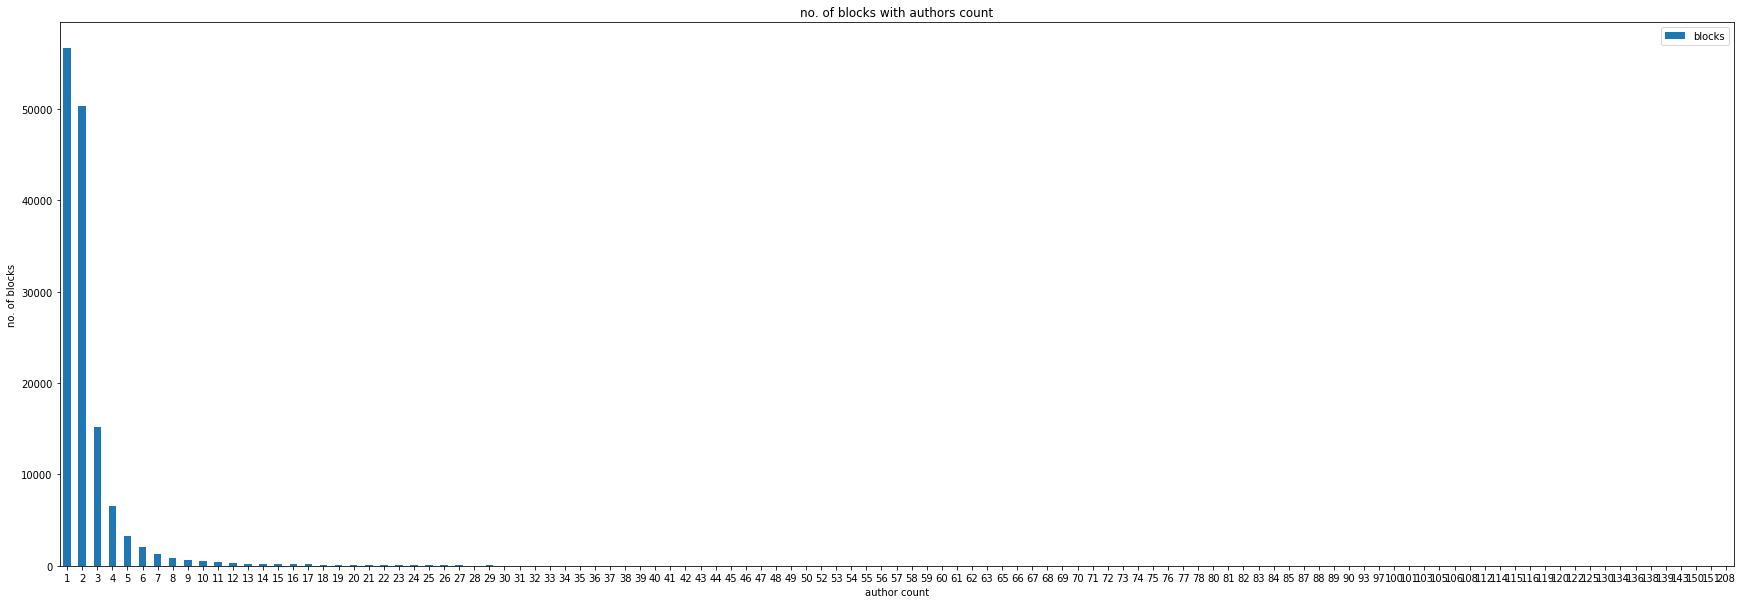

In [10]:
cluster_query = "select author_count, count(*) as blocks from clusters_x10 group by author_count order by author_count"
print(pd.read_sql_query(cluster_query,cnx))
data = pd.read_sql_query(cluster_query,cnx)
data.to_excel('Blocks_vs_authors.xlsx')
ax = data.plot.bar(y='blocks', x='author_count', rot=0, figsize=(30,10), title='no. of blocks with authors count')
# ax = data.plot.hist(y='blocks', x='author_count', bins=100, figsize=(30,10), title='no. of blocks with authors count')
ax.set_xlabel("author count")
ax.set_ylabel("no. of blocks")
# print(ax)
plot.show()

Histogram of blocks with publication year difference(max)

In [3]:
query = "select articles_2_ab.id, first_initial,last_name, year from articles_2_ab inner join publication on articles_2_ab.id=publication.id order by first_initial,last_name"
data = pd.read_sql_query(query,cnx)
print(data)

                              id first_initial    last_name  year
0                       42593564                   "KEMPAS"  1941
1                        4255134                 Afriastini  1989
2                        4298046                      Alain  1992
3                       20183520                Ambariyanto  2008
4                        4222064                Ambariyanto  1998
...                          ...           ...          ...   ...
1009183  mounresedeve.32.3ru.r29             Я     Janecka)  2012
1009184                 43519399             Я      Михалко  1980
1009185                 23780384             Я       ПРОКСА  1980
1009186   mounresedeve.32.3ru.r3             п    редакторы  2012
1009187                 24130708             •          Kim  2010

[1009188 rows x 4 columns]


In [4]:
data_group_by_fl = data.groupby(["first_initial","last_name"])
years_to_block_count = {}
for group_name, df_group in data_group_by_fl:
    if len(df_group["id"]) > 1:
        years = sorted(df_group["year"])
        diff = years[len(years)-1]-years[0]
        if diff not in years_to_block_count:
            years_to_block_count[diff] = 0
        years_to_block_count[diff] += 1
# print(years_to_block_count)


In [5]:
# years_data = pd.DataFrame.from_records([years_to_block_count])
years_plot_data = pd.DataFrame()
years_plot_data["diff"] = sorted(years_to_block_count.keys())
years_plot_data["block_count"] = [years_to_block_count[x] for x in sorted(years_to_block_count.keys())]
print(years_plot_data)
years_plot_data.to_excel('blocks_publication_year_diff.xlsx')


     diff  block_count
0       0         6863
1       1         8809
2       2         7833
3       3         7049
4       4         5973
..    ...          ...
174   174            4
175   175            2
176   176            2
177   177            4
178   179            1

[179 rows x 2 columns]


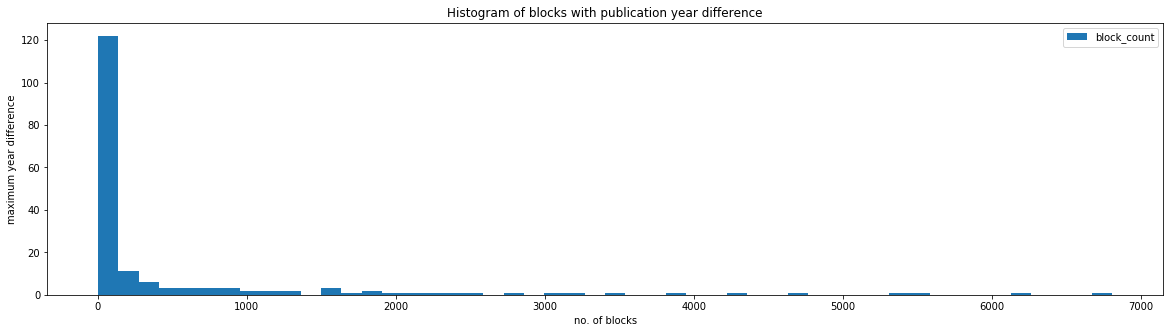

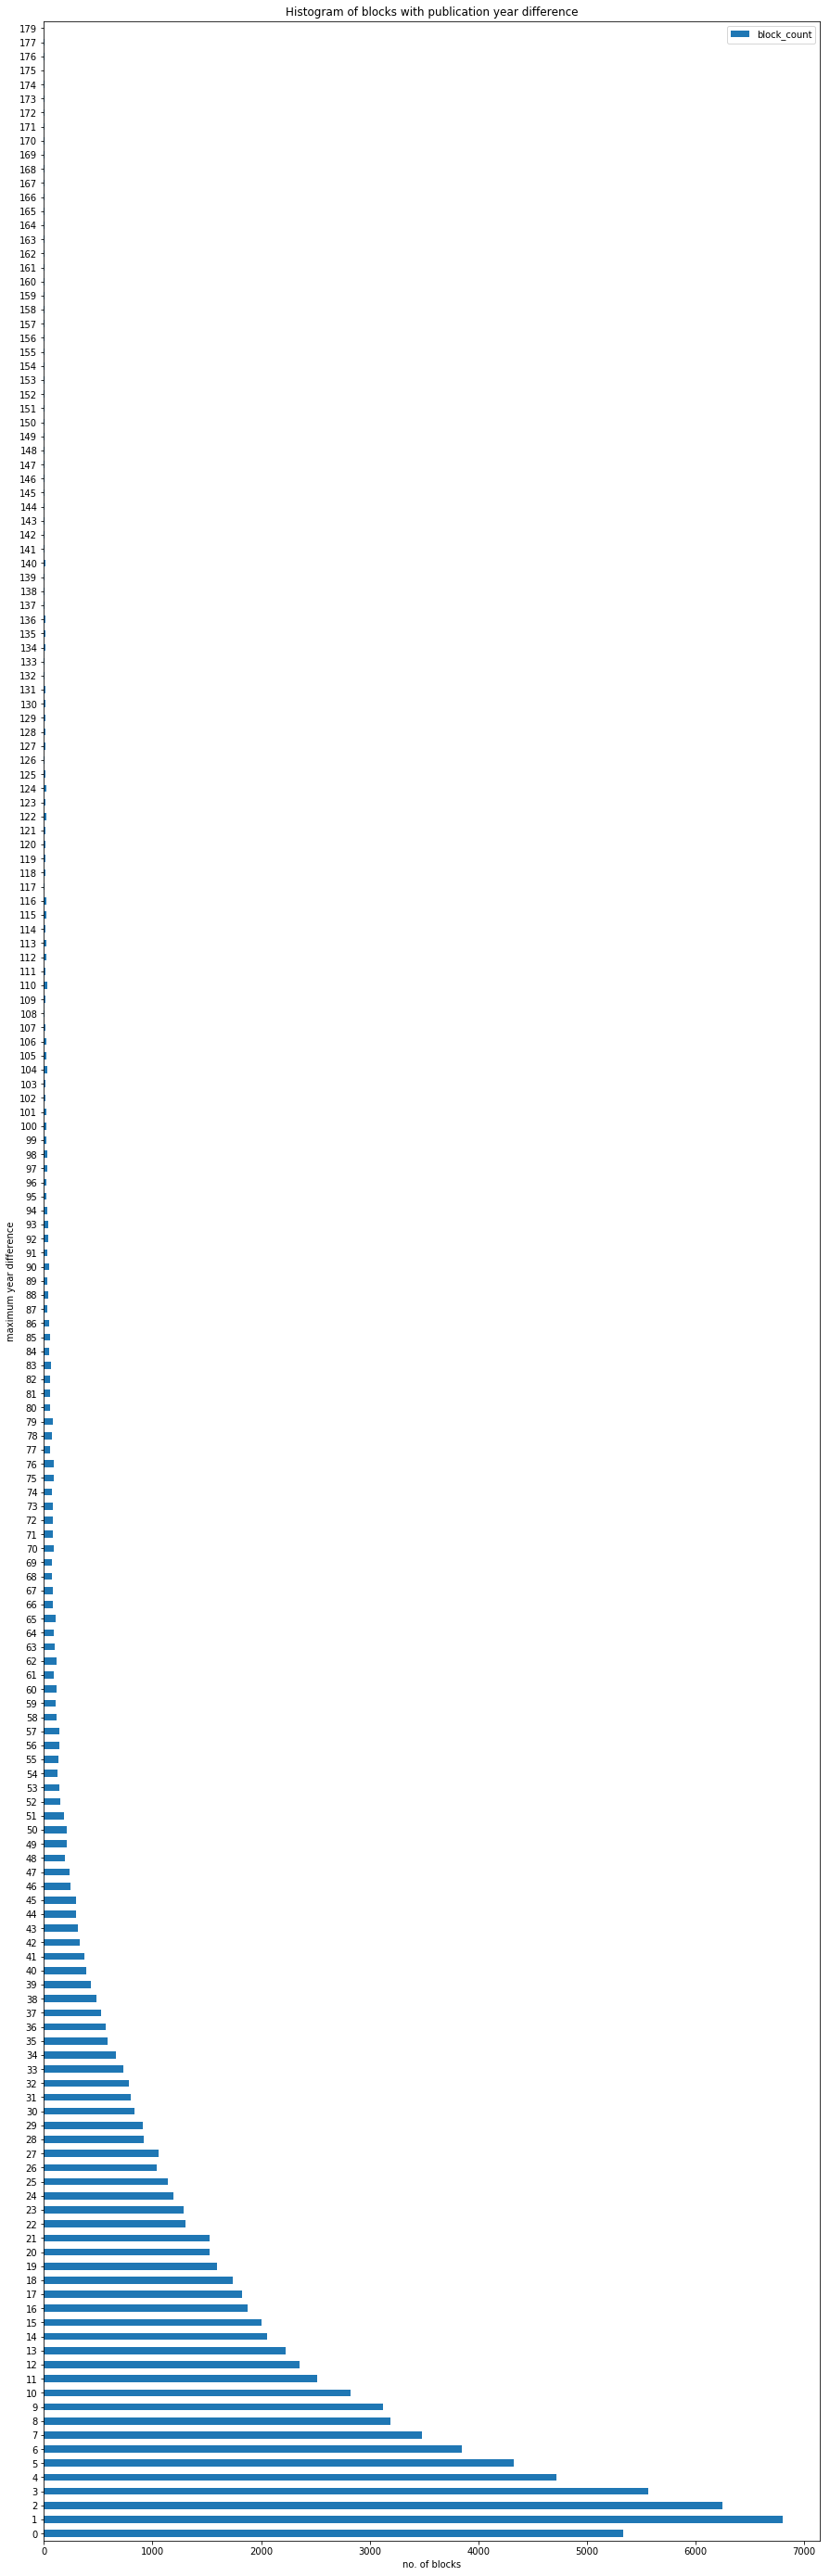

In [91]:
# ax = years_plot_data.plot.barh(x='diff', y='block_count', rot=0, figsize=(15,50), title='Histogram of blocks with publication year difference')
ax = years_plot_data.plot.hist(x='diff', y='block_count', bins=50, figsize=(20,5), title='Histogram of blocks with publication year difference')
ax.set_ylabel("maximum year difference")
ax.set_xlabel("no. of blocks")
plot.show()

ax = years_plot_data.plot.barh(x='diff', y='block_count', rot=0, figsize=(15,50), title='Histogram of blocks with publication year difference')
ax.set_ylabel("maximum year difference")
ax.set_xlabel("no. of blocks")
plot.show()

unique authors after clustering

In [76]:
# print("total authors before clustering")
query = "select count(distinct fullname) as total_authors from articles_2_ab"
print(pd.read_sql_query(query,cnx))

# total no of authors not considered for clustering
# get total blocks with one paper and no. of authors in those blocks
# query = "select count(*) as total_authors_not_considered_for_clustering from (select distinct first_initial,last_name, count(distinct id) as c from articles_2_ab group by first_initial,last_name having c = 1)"
# print(pd.read_sql_query(query,cnx))

# # total no of authors considered for clustering
# query = "select count(*) as total_authors_considered_for_clustering from (select distinct first_initial,last_name, count(distinct id) as c from articles_2_ab group by first_initial,last_name having c > 1)"
# print(pd.read_sql_query(query,cnx))

query = "select sum(author_count) as total_authors_before_clustering from clusters_x10"
print(pd.read_sql_query(query,cnx))

query = "select sum(total_clusters) as total_authors_after_clustering from clusters_x10"
print(pd.read_sql_query(query,cnx))
#todo: MUST use author name strings

   total_authors
0         507951
   total_authors_before_clustering
0                           342978
   total_authors_after_clustering
0                          197883


Graph plot unique author names vs identified authors per year (diff?).

In [10]:
import ast
query = "select clusters, total_clusters as identified_authors, author_count as unique_author_names from clusters_x10"
cluster_data = pd.read_sql_query(query,cnx)

year_data_ = pd.read_sql_query("select id, year from publication",cnx)
final_df = pd.DataFrame(columns = ["diff", "identified_authors", "author_count"])

for index, row in cluster_data.iterrows():
    clusters = ast.literal_eval(row["clusters"])
    cluster_ids = [cluster.split(';') for cluster in clusters]
    cluster_ids_list = []
    for id in cluster_ids:
        for id_ in id:
            cluster_ids_list.append(str(id_))
    cluster_ids_list = cluster_ids_list[0:len(cluster_ids_list)-1]
    year_data = year_data_[year_data_.id.isin(cluster_ids_list)]
    diff = year_data["year"].max() - year_data["year"].min()
    temp_df = pd.DataFrame([[diff,row["identified_authors"],row["unique_author_names"]]],columns = ["diff", "identified_authors", "author_count"])
    final_df = final_df.append(temp_df)
#     break
print(final_df)

   diff identified_authors author_count
0     2                  1            3
0    11                  2            4
0     4                  1            1
0     2                  1            1
0     4                  1            2
..  ...                ...          ...
0    12                  1            1
0    15                  1            2
0     0                  2            2
0    17                  1            2
0     1                  1            1

[140078 rows x 3 columns]


In [11]:
final_df = final_df.dropna()
final_df_group_by_diff = final_df.groupby(["diff"]).agg({'identified_authors':sum,'author_count':sum})
final_df_group_by_diff.to_excel("author_names_vs_identified_authors.xlsx")
print(final_df_group_by_diff)

      identified_authors  author_count
diff                                  
0                  51888         71240
1                   3956          5996
2                   3994          6167
3                   3905          6259
4                   3617          5911
...                  ...           ...
173                   64           141
174                   10            17
175                    8            23
176                   11            32
177                   19            35

[178 rows x 2 columns]


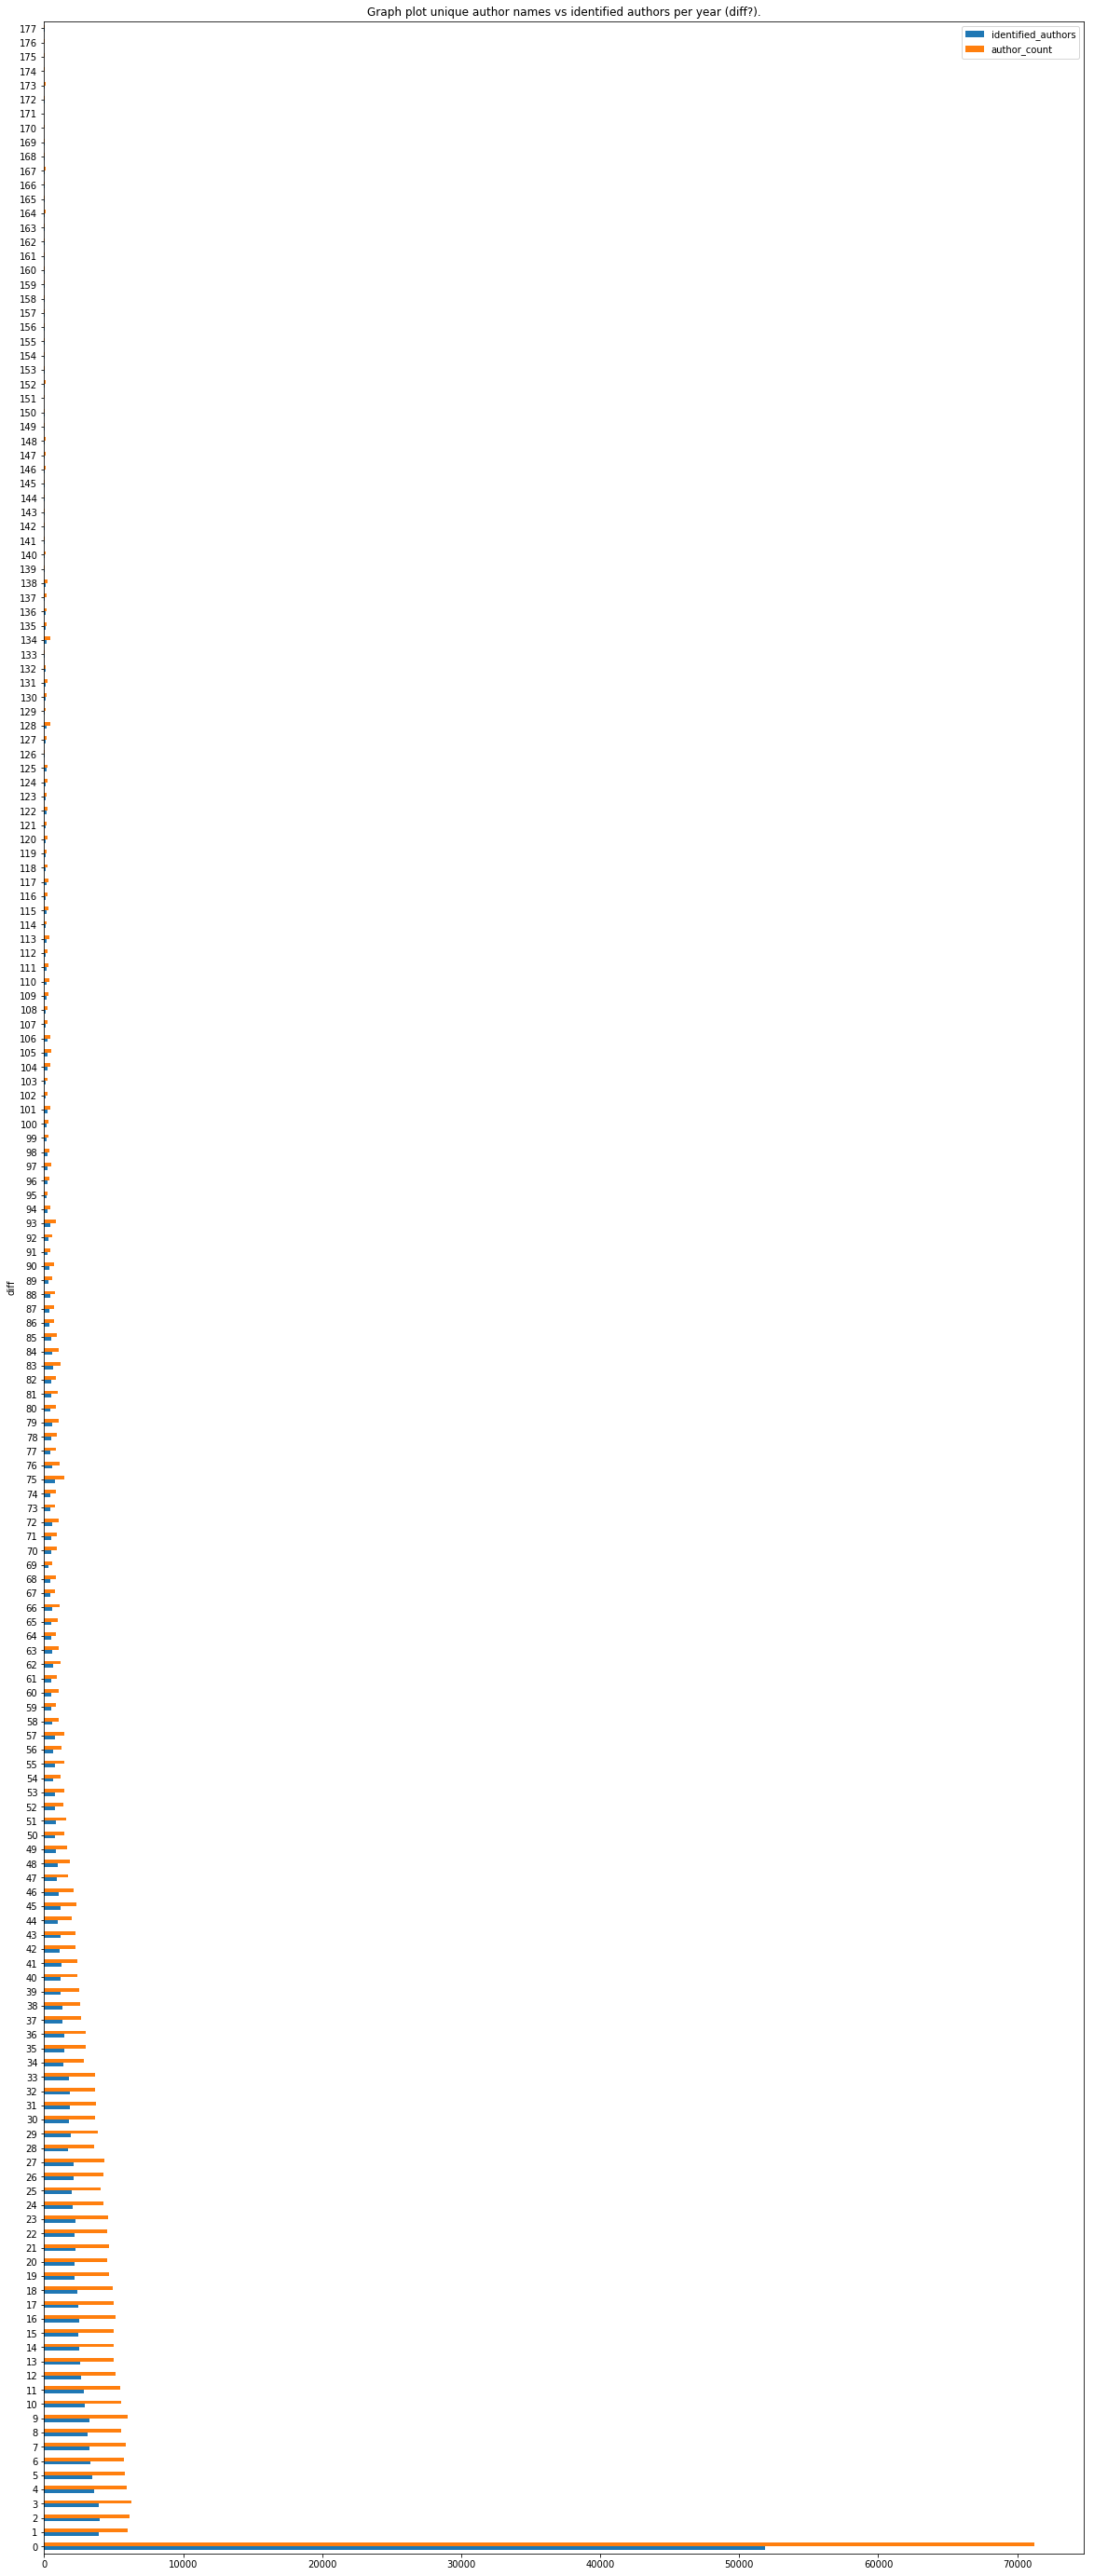

NameError: name 'final_df_group_by_difffinal_df_group_by_diff' is not defined

In [12]:
# final_df_group_by_diff.to_excel('output.xlsx')
# final_df_group_by_diff['percentage'] = final_df_group_by_diff.apply(lambda x: (x.identified_authors/x.author_count)*100, axis=1)
# print(final_df_group_by_diff)
ax = final_df_group_by_diff.plot.barh(rot=0, figsize=(20,50), title="Graph plot unique author names vs identified authors per year (diff?).")
plot.show()
final_df_group_by_diff['percentage'] = final_df_group_by_difffinal_df_group_by_diff.apply(lambda x: (x.gs_counts/x.jstor_counts)*100, axis=1)
print(final_df_group_by_diff)
ax = final_df_group_by_diff.plot.barh(x='year',y='percentage',rot=0, figsize=(15,50), title='Graph plot unique author names vs identified authors per year %')
# ax.set_xlabel("year")
# ax.set_ylabel("% of articles found in google scholar")
plot.show()

Author names with first name over the years and middle initial over the years.

In [119]:
query = "select first_name, middle_initial, year from articles_2_ab inner join publication on articles_2_ab.id=publication.id "
author_name_analysis = pd.read_sql_query(query,cnx)
# print(author_name_analysis)
# author_name_group_by_first = author_name_analysis.groupby(["year"])['first_name'].apply(lambda x: (x!='').sum()).reset_index(name='first_count')
author_name_group_by_middle = author_name_analysis.groupby(["year"])['middle_initial'].apply(lambda x: (x!='').sum()).reset_index(name='middle_count')
# print(author_name_group_by_first)
# print(author_name_group_by_middle)

In [120]:
df = pd.concat([author_name_group_by_first,author_name_group_by_middle["middle_count"]],axis = 1)
# df = df.rename(columns={"year":"year","count":"firstname_count","count":"middle_initial_count"})

In [121]:
# print(df.columns)
df = df.set_index('year')

In [ ]:
# df['year_range'] = df.apply()

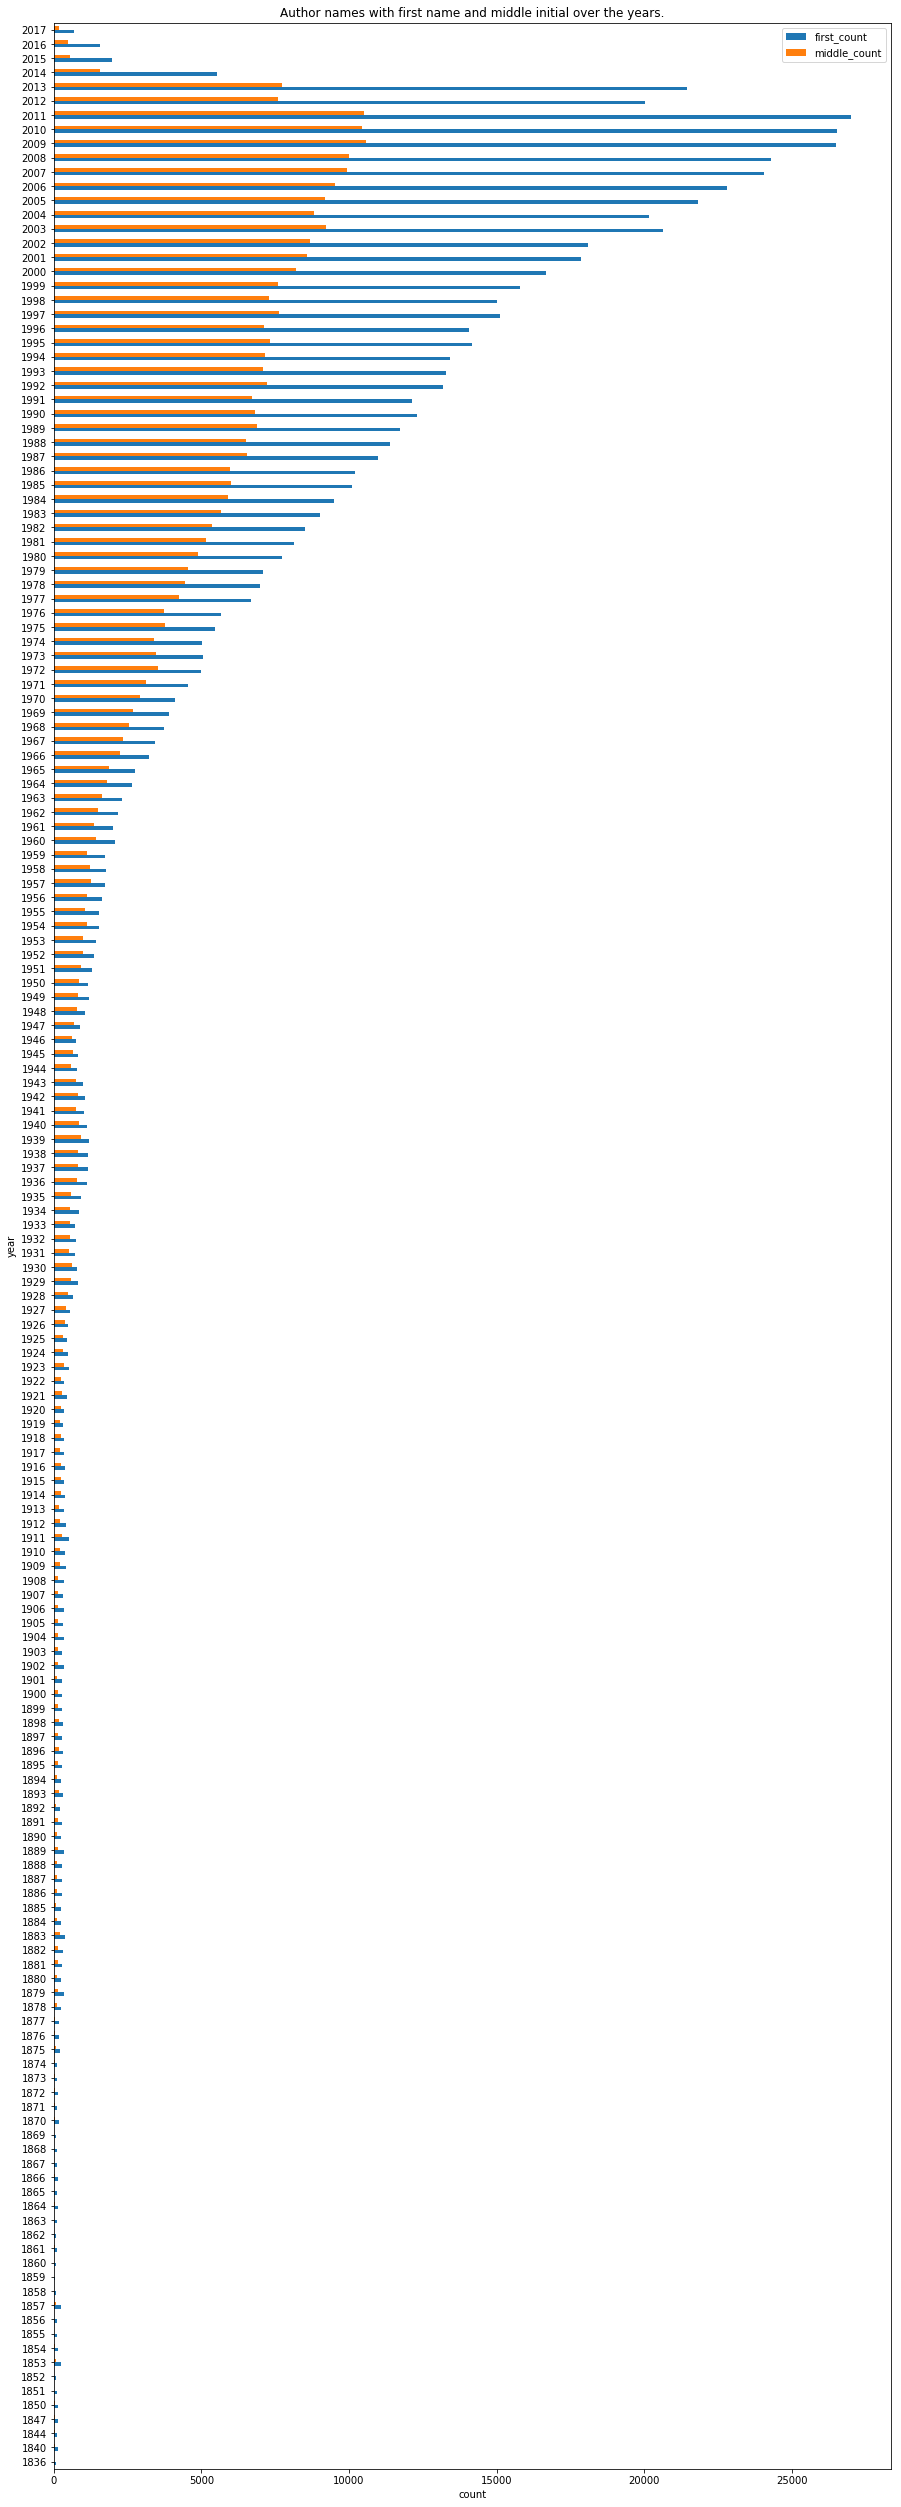

      first_count  middle_count     ratio
year                                     
1836           63            19  0.301587
1840          132            55  0.416667
1844          120            48  0.400000
1847          159            59  0.371069
1850          130            55  0.423077
...           ...           ...       ...
2013        21428          7743  0.361350
2014         5521          1584  0.286905
2015         1966           548  0.278739
2016         1560           499  0.319872
2017          691           169  0.244573

[172 rows x 3 columns]


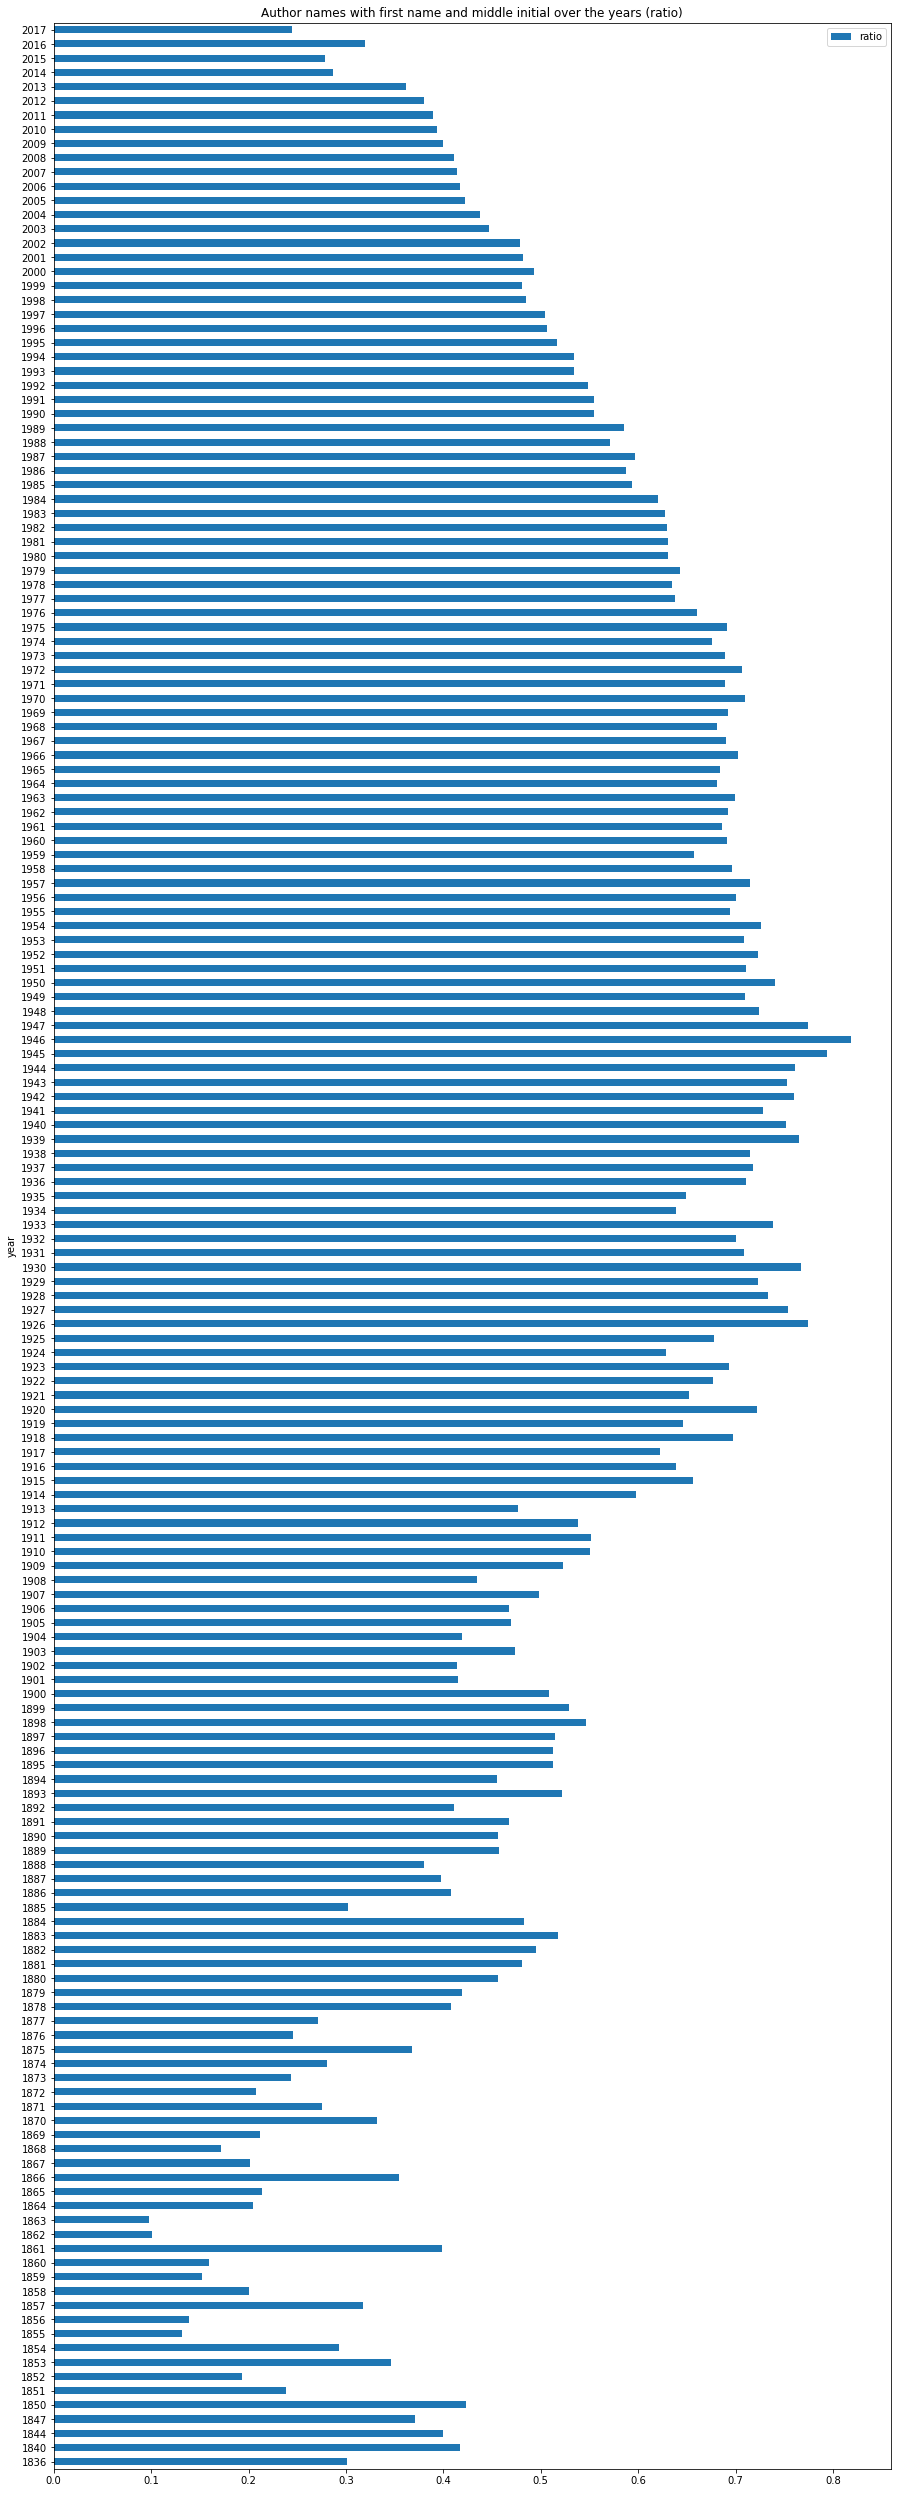

In [122]:
# print(df)
# ax = df.plot.hist(bins=50,figsize=(15,15),title="Author names with first name and middle initial over the years.")
ax = df.plot.barh(rot=0,figsize=(15,45),title="Author names with first name and middle initial over the years.")
ax.set_ylabel("year")
ax.set_xlabel("count")
plot.show()
df['ratio'] = df.apply(lambda x: (x.middle_count/x.first_count), axis=1)
print(df)
df = df.reset_index()
ax = df.plot.barh(x='year',y='ratio',figsize=(15,45),title="Author names with first name and middle initial over the years (ratio)")
# ax = df.plot.bar(y='ratio',rot=0, figsize=(15,50), title='Author names with first name and middle initial over the years. %')
# ax.set_xlabel("year")
# ax.set_ylabel("% of articles found in google scholar")
plot.show()

    year  gs_counts  jstor_counts
0   2001       1529          9036
1   2002       1643          8942
2   2003       2023          9759
3   2004       2181          9675
4   2005       2365         10112
5   2006       2545         10402
6   2007       2796         10649
7   2008       2897         11192
8   2009       3098         10853
9   2010       3020         10441
10  2011       3203         10040
11  2012       2342          7205
12  2013       2367          7330
13  2014       1023          3191
14  2015        186          1095
15  2016        118           424
16  2017         42           190


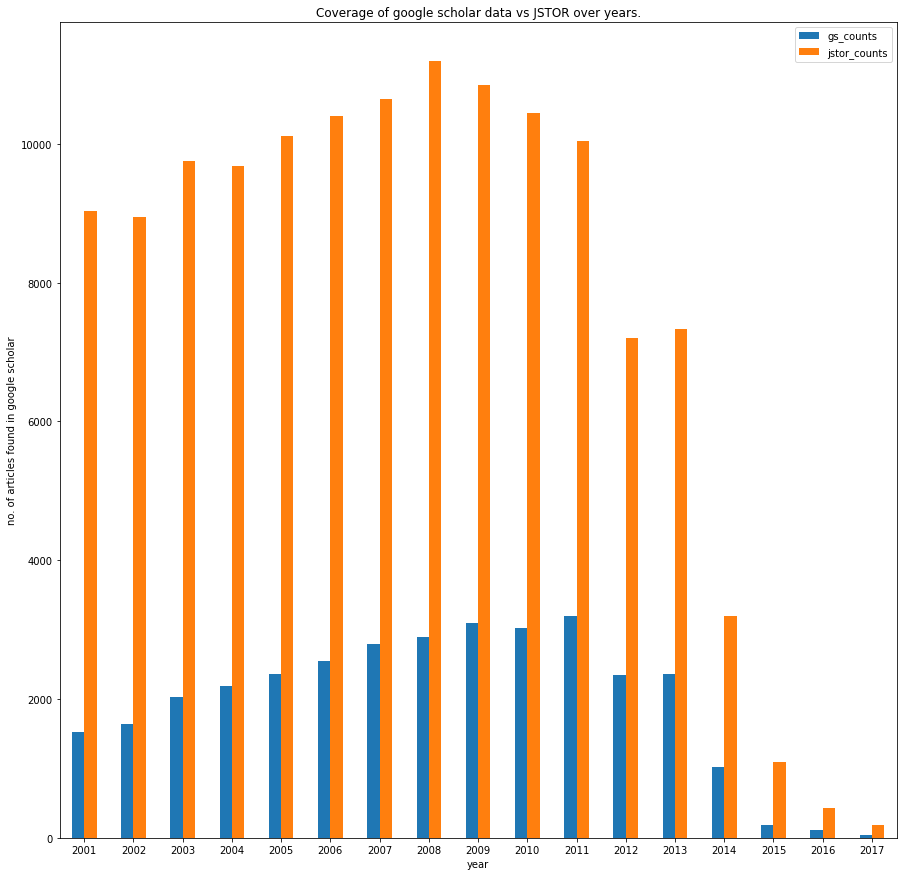

      gs_counts  jstor_counts  percentage
year                                     
2001       1529          9036    0.169212
2002       1643          8942    0.183740
2003       2023          9759    0.207296
2004       2181          9675    0.225426
2005       2365         10112    0.233881
2006       2545         10402    0.244664
2007       2796         10649    0.262560
2008       2897         11192    0.258846
2009       3098         10853    0.285451
2010       3020         10441    0.289244
2011       3203         10040    0.319024
2012       2342          7205    0.325052
2013       2367          7330    0.322920
2014       1023          3191    0.320589
2015        186          1095    0.169863
2016        118           424    0.278302
2017         42           190    0.221053


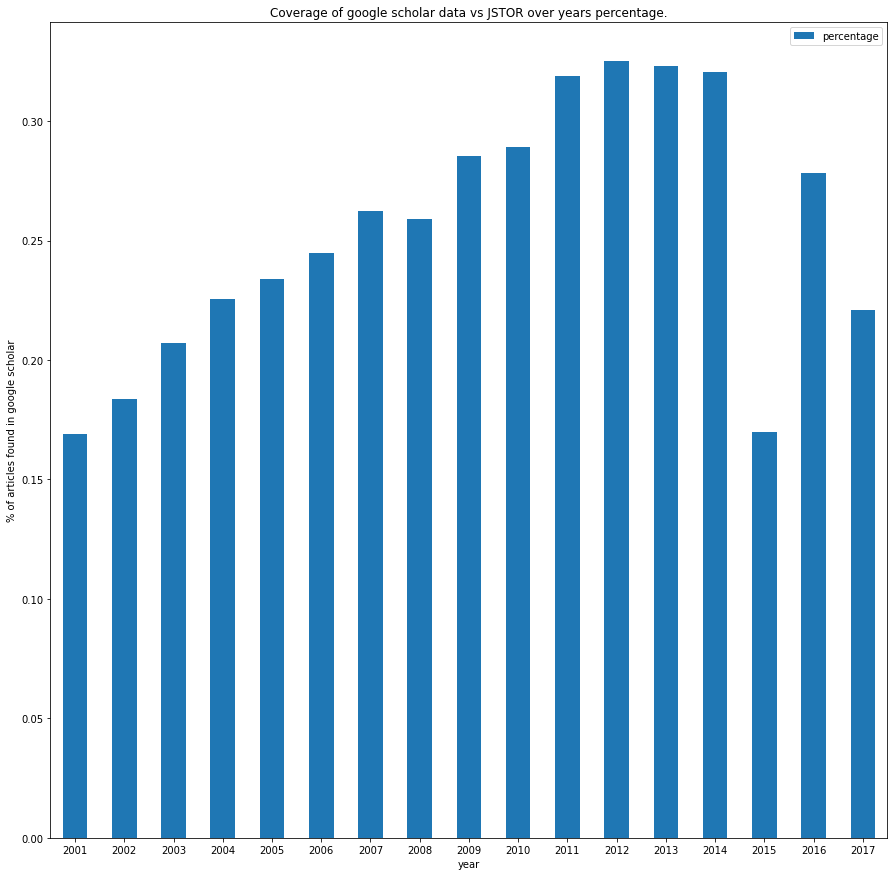

In [58]:
print(counts_both_merged)
counts_both_merged = counts_both_merged.set_index('year')
ax = counts_both_merged.plot.bar(rot=0, figsize=(15,15), title='Coverage of google scholar data vs JSTOR over years.')
ax.set_xlabel("year")
ax.set_ylabel("no. of articles found in google scholar")
plot.show()
counts_both_merged['percentage'] = counts_both_merged.apply(lambda x: (x.gs_counts/x.jstor_counts), axis=1)
print(counts_both_merged)
ax = counts_both_merged.plot.bar(y='percentage',rot=0, figsize=(15,15), title='Coverage of google scholar data vs JSTOR over years percentage.')
ax.set_xlabel("year")
ax.set_ylabel("% of articles found in google scholar")
plot.show()

#todo: jstor artciles include
#todo: line plot - on all gs, bhl and self

Coverage of validation data over the years.

In [65]:
query = "select ids from google_scholar"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
# print(gs_data)



articles_query = "select id, year from publication where year > 2000"
articles_data = pd.read_sql_query(articles_query,cnx)
print(articles_data)

merged_data_gs = pd.merge(gs_data, articles_data, how="inner", on=["id"])
# print(merged_data_gs)
merged_data_gs.drop_duplicates()


                             id  year
0                      43215559  2004
1                      41288662  2011
2                      23500443  2013
3       bullecosociamer.84.3.97  2003
4                      43576632  2010
...                         ...   ...
130531                  3061482  2001
130532                 20068906  2006
130533                 27651391  2007
130534                 25150871  2008
130535                 27651688  2008

[130536 rows x 2 columns]


,id,year
0,4315162,2001
1,4280408,2002
2,4095003,2005
3,4095942,2006
4,4315445,2003
...,...,...
33373,40928128,2010
33374,4223305,2002
33375,23391634,2010
33376,23727966,2009


In [57]:
journal_to_ids_count_data = merged_data_gs.groupby(["year"]).size().reset_index(name="gs_counts")
journal_to_ids_count_data_jstor = articles_data.groupby(["year"]).size().reset_index(name="jstor_counts")
# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data, journal_to_ids_count_data_jstor, how="inner", on=["year"])
print(counts_both_merged)

    year  gs_counts  jstor_counts
0   2001       1529          9036
1   2002       1643          8942
2   2003       2023          9759
3   2004       2181          9675
4   2005       2365         10112
5   2006       2545         10402
6   2007       2796         10649
7   2008       2897         11192
8   2009       3098         10853
9   2010       3020         10441
10  2011       3203         10040
11  2012       2342          7205
12  2013       2367          7330
13  2014       1023          3191
14  2015        186          1095
15  2016        118           424
16  2017         42           190


Coverage of bhl over years

In [59]:
query = "select ids from self_citations where ids like '%,%'"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
print(gs_data)


merged_data_self = pd.merge(gs_data, articles_data, how="inner", on=["id"])
print(merged_data_self)
merged_data_self.drop_duplicates()


                   id
0      10.1086/303276
1            43214461
2             4215286
3             4215327
4             4221739
...               ...
79356        43216070
79357        43226878
79358         2656159
79359        41242835
79361        23727916

[63264 rows x 1 columns]
             id  year
0       4601947  2001
1       4315642  2005
2       4315643  2005
3       4281392  2003
4       4356807  2005
...         ...   ...
17063  20181842  2008
17064  25547845  2008
17065  23728225  2012
17066   2656159  2001
17067  41242835  2011

[17068 rows x 2 columns]


,id,year
0,4601947,2001
1,4315642,2005
2,4315643,2005
3,4281392,2003
4,4356807,2005
...,...,...
17063,20181842,2008
17064,25547845,2008
17065,23728225,2012
17066,2656159,2001


In [60]:
journal_to_ids_count_data_self = merged_data_self.groupby(["year"]).size().reset_index(name="self_counts")
journal_to_ids_count_data_jstor = articles_data.groupby(["year"]).size().reset_index(name="jstor_counts")
print(counts_both_merged)

# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data_self, journal_to_ids_count_data_jstor, how="inner", on=["year"])
counts_both_merged = pd.merge(journal_to_ids_count_data,counts_both_merged, how="inner", on=["year"])
print(counts_both_merged)

      gs_counts  jstor_counts  percentage
year                                     
2001       1529          9036    0.169212
2002       1643          8942    0.183740
2003       2023          9759    0.207296
2004       2181          9675    0.225426
2005       2365         10112    0.233881
2006       2545         10402    0.244664
2007       2796         10649    0.262560
2008       2897         11192    0.258846
2009       3098         10853    0.285451
2010       3020         10441    0.289244
2011       3203         10040    0.319024
2012       2342          7205    0.325052
2013       2367          7330    0.322920
2014       1023          3191    0.320589
2015        186          1095    0.169863
2016        118           424    0.278302
2017         42           190    0.221053
    year  gs_counts  self_counts  jstor_counts
0   2001       1529         1072          9036
1   2002       1643         1155          8942
2   2003       2023         1225          9759
3   2004      

      gs_counts  self_counts  jstor_counts
year                                      
2001       1529         1072          9036
2002       1643         1155          8942
2003       2023         1225          9759
2004       2181         1174          9675
2005       2365         1429         10112
2006       2545         1485         10402
2007       2796         1484         10649
2008       2897         1543         11192
2009       3098         1499         10853
2010       3020         1399         10441
2011       3203         1360         10040
2012       2342          889          7205
2013       2367          921          7330
2014       1023          349          3191
2015        186           42          1095
2016        118           30           424
2017         42           12           190


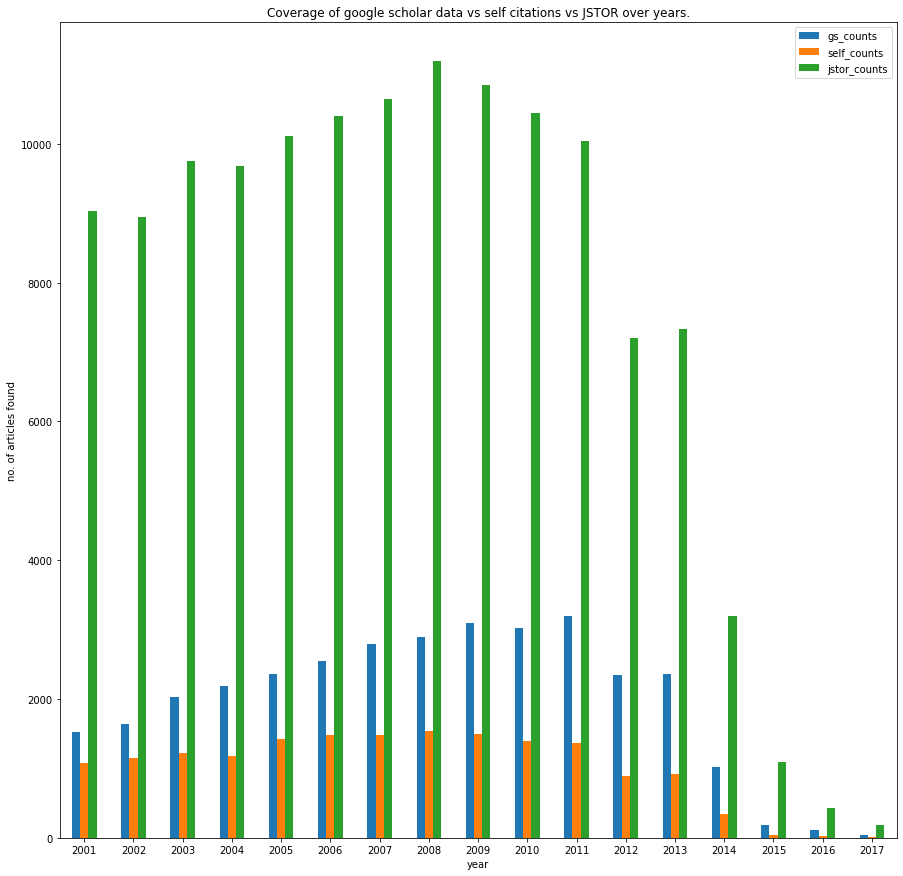

In [64]:
print(counts_both_merged)
# counts_both_merged.reset_index()
# counts_both_merged = counts_both_merged.set_index('year')
ax = counts_both_merged.plot.bar(rot=0, figsize=(15,15), title='Coverage of google scholar data vs self citations vs JSTOR over years.')
ax.set_xlabel("year")
ax.set_ylabel("no. of articles found")
plot.show()
# counts_both_merged['percentage'] = counts_both_merged.apply(lambda x: (x.gs_counts/x.jstor_counts), axis=1)
# print(counts_both_merged)
# ax = counts_both_merged.plot.bar(y='ratio',rot=0, figsize=(15,50), title='Coverage of google scholar data vs JSTOR over years percentage.')
# ax.set_xlabel("year")
# ax.set_ylabel("% of articles found in google scholar")
# plot.show()

Coverage of validation data over journals.

In [62]:
query = "select ids from google_scholar"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
# print(gs_data)

articles_query = "select id, journal_name from articles_2_ab"
articles_data = pd.read_sql_query(articles_query,cnx)
# print(articles_data)

merged_data = pd.merge(gs_data, articles_data, how="inner", on=["id"])
# print(merged_data)
merged_data.drop_duplicates()
journal_to_ids_count_data = merged_data.groupby(["journal_name"]).size().reset_index(name="gs_counts")

                              journal_name  gs_counts  jstor_counts
0                                AAV Today         12           273
1                       Abstracta Botanica         21           522
2                Acta Botánica Venezuélica          4           750
3        Advances in Horticultural Science         62          2900
4                                    Ambio       4291          9959
..                                     ...        ...           ...
209  Wildlife Society Bulletin (1973-2006)       2501          8690
210      Wildlife Society Bulletin (2011-)         52           444
211                            Willdenowia        452          2381
212                             Worldviews         40           225
213                             Écoscience         11          2605

[214 rows x 3 columns]


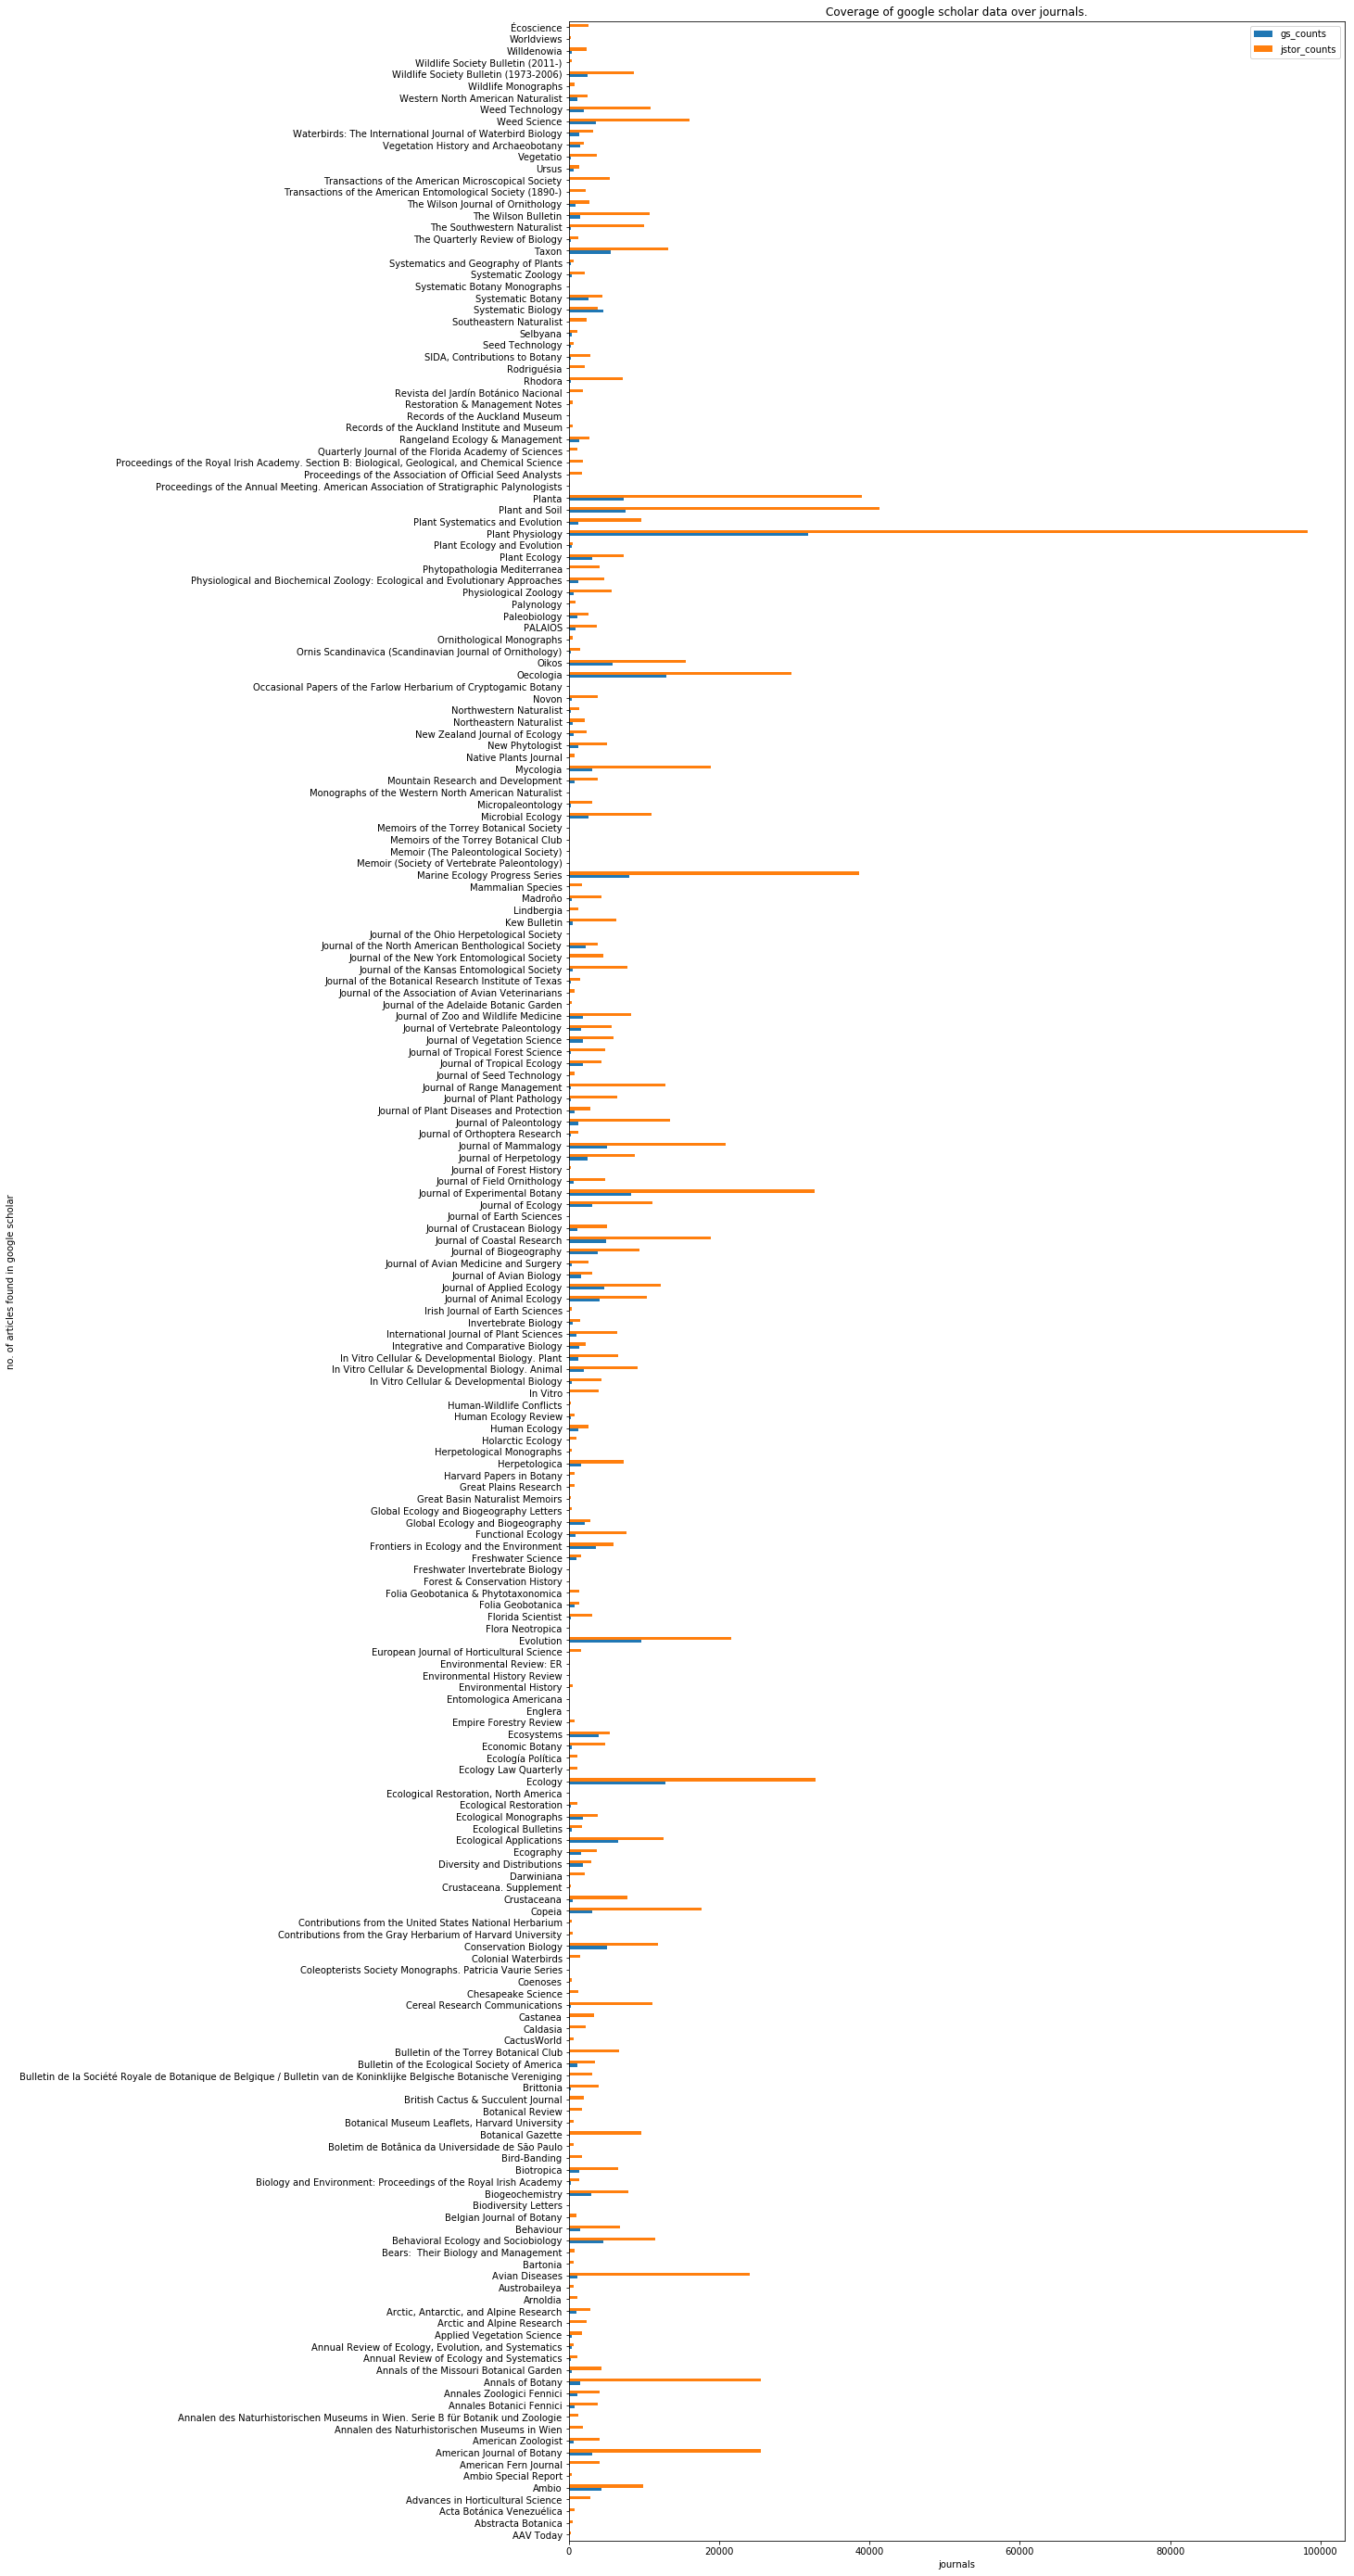

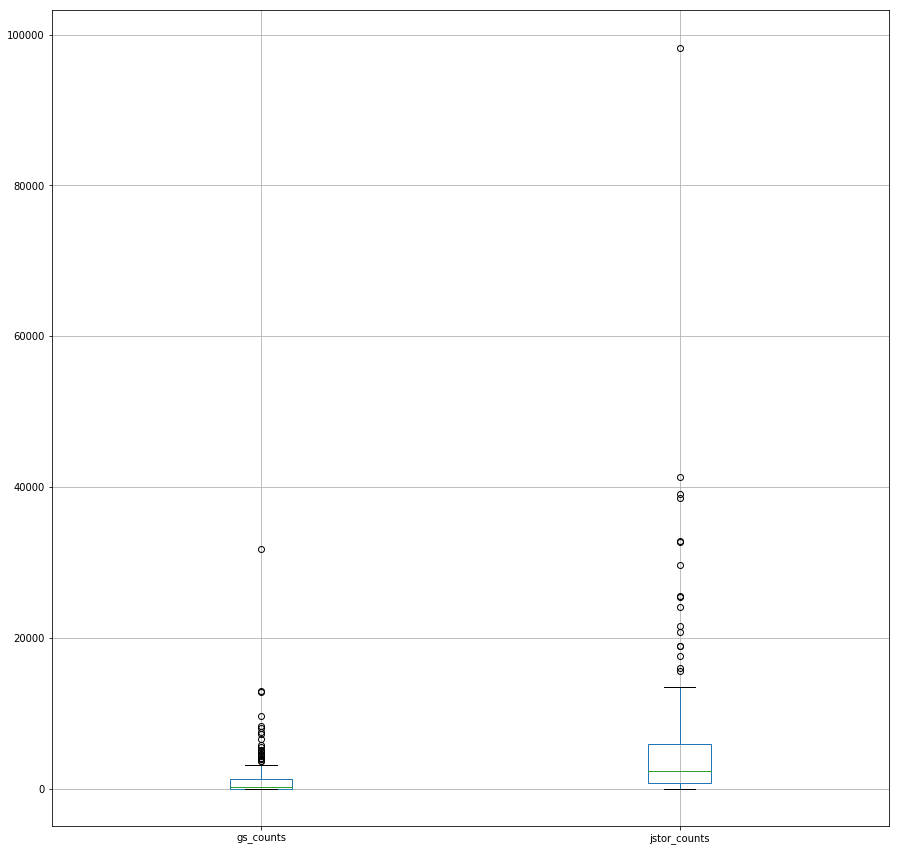

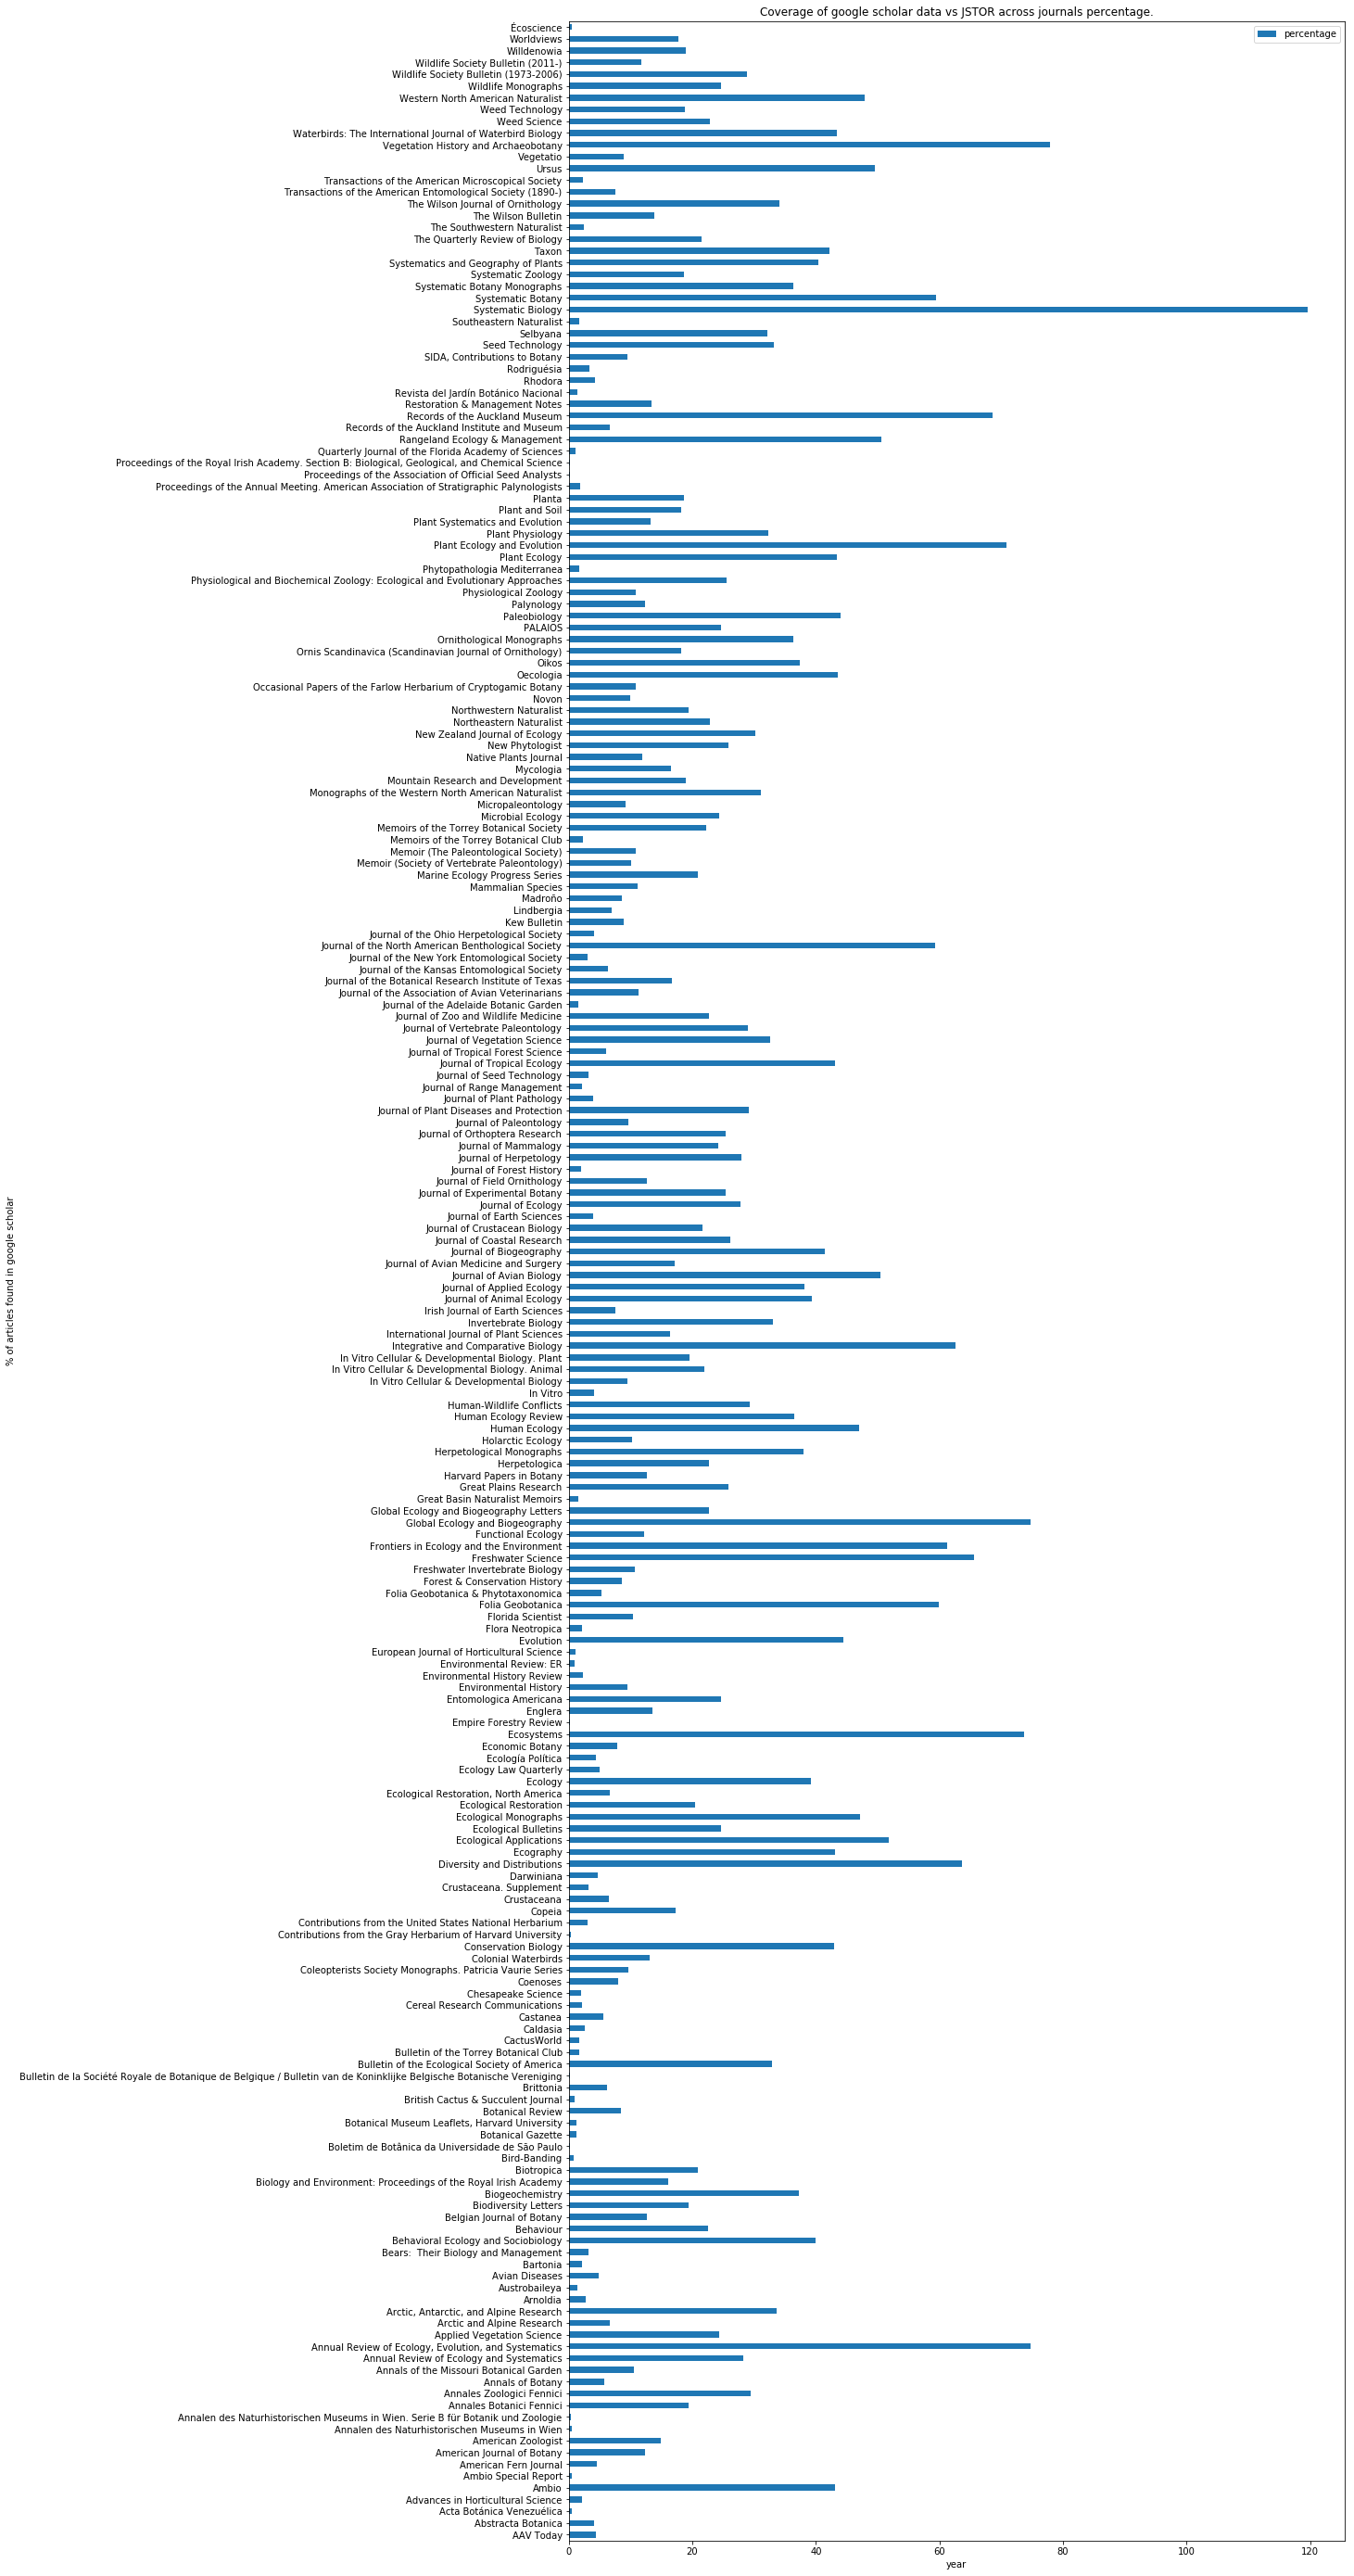

In [63]:
journal_to_ids_count_data_jstor = articles_data.groupby(["journal_name"]).size().reset_index(name="jstor_counts")
# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data, journal_to_ids_count_data_jstor, how="inner", on=["journal_name"])
print(counts_both_merged)
counts_both_merged = counts_both_merged.set_index('journal_name')

# print(journal_to_ids_count_data)
ax = counts_both_merged.plot.barh( rot=0, figsize=(15,50), title='Coverage of google scholar data over journals.')
ax.set_xlabel("journals")
ax.set_ylabel("no. of articles found in google scholar")
plot.show()
counts_both_merged.boxplot(column=['gs_counts', 'jstor_counts'],figsize=(15,15))
counts_both_merged['percentage'] = counts_both_merged.apply(lambda x: (x.gs_counts/x.jstor_counts)*100, axis=1)
# print(counts_both_merged)
ax = counts_both_merged.plot.barh(y='percentage',rot=0, figsize=(15,50), title='Coverage of google scholar data vs JSTOR across journals percentage.')
ax.set_xlabel("year")
ax.set_ylabel("% of articles found in google scholar")
plot.show()
# line = plot.barh(journal_to_ids_count_data["counts"][0:50],journal_to_ids_count_data["journal_name"][0:50])
# plot.title("coverage of validation data over journals")
# plot.xlabel('journals')
# plot.ylabel("no. of articles found")
# plot.show()
#todo: include jstor articles. a box plot

Coverage of validation data over journals bhl.

In [133]:
query = "select ids from bhl"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
# print(gs_data)

articles_query = "select id, journal_name from articles_2_ab"
articles_data = pd.read_sql_query(articles_query,cnx)
# print(articles_data)

merged_data = pd.merge(gs_data, articles_data, how="inner", on=["id"])
# print(merged_data)
merged_data.drop_duplicates()
journal_to_ids_count_data = merged_data.groupby(["journal_name"]).size().reset_index(name="gs_counts")

                                         journal_name  gs_counts  jstor_counts
0   Quarterly Journal of the Florida Academy of Sc...        218          1149
1                                             Rhodora       2058          7225
2                                         Rodriguésia        204          2114
3                       SIDA, Contributions to Botany       1034          2912
4                                   Systematic Botany          3          4471
5                                               Taxon          6         13228
6                                 The Wilson Bulletin       5102         10781
7                   The Wilson Journal of Ornithology        167          2737
8   Transactions of the American Entomological Soc...         53          2274
9   Transactions of the American Entomological Soc...          7           111
10  Transactions of the American Microscopical Soc...         96          5437


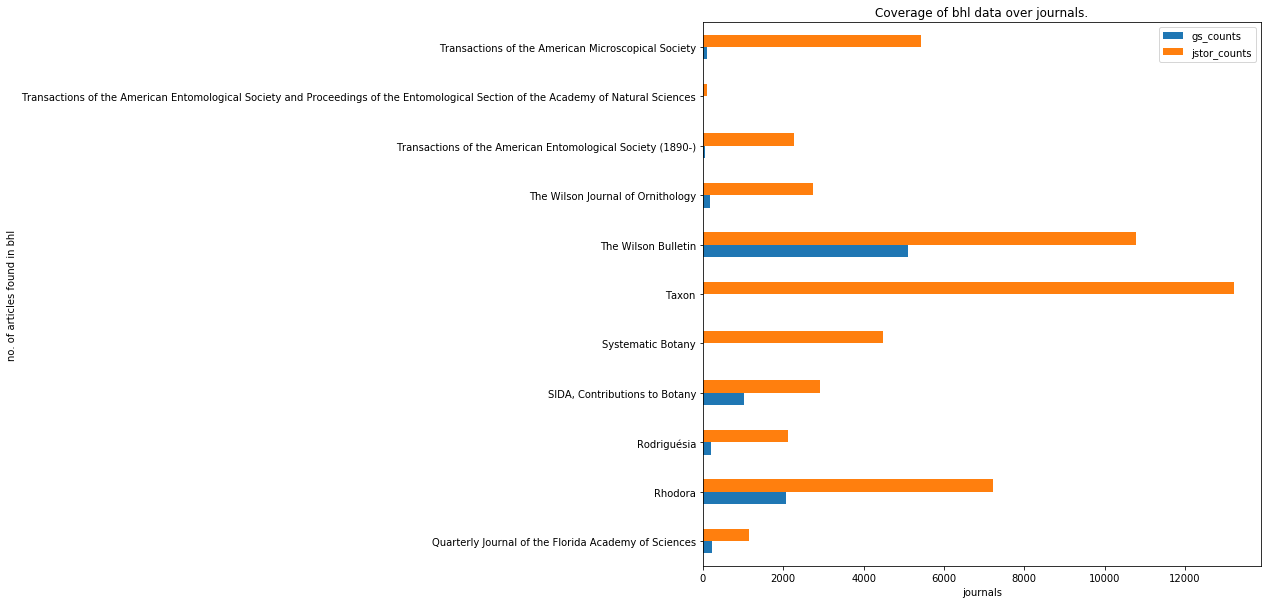

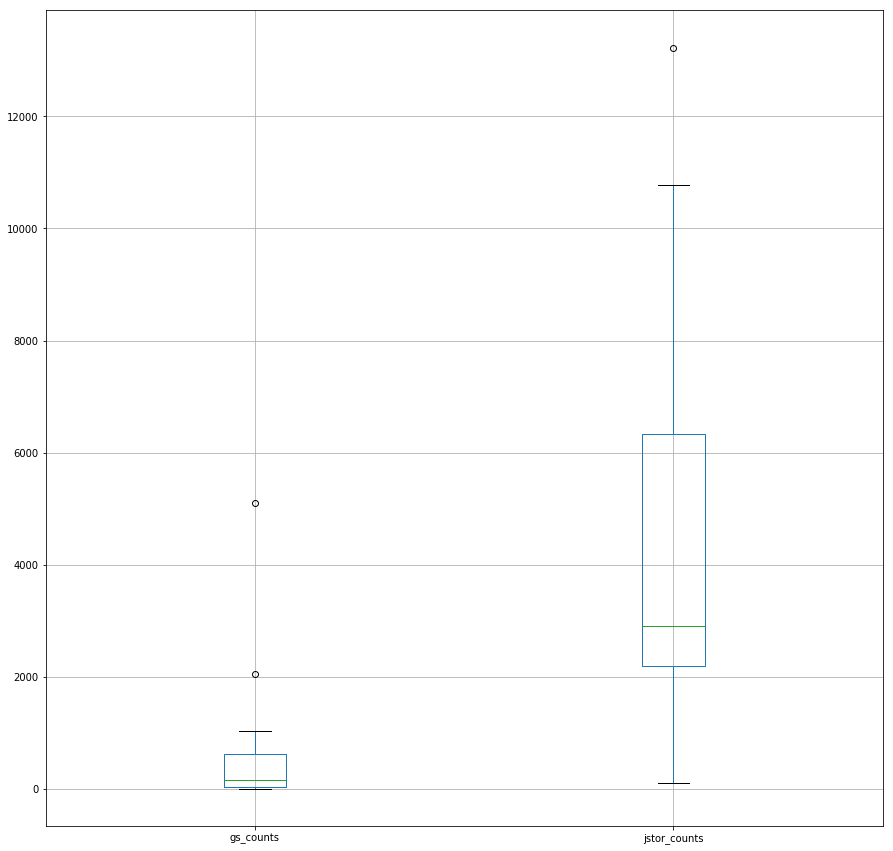

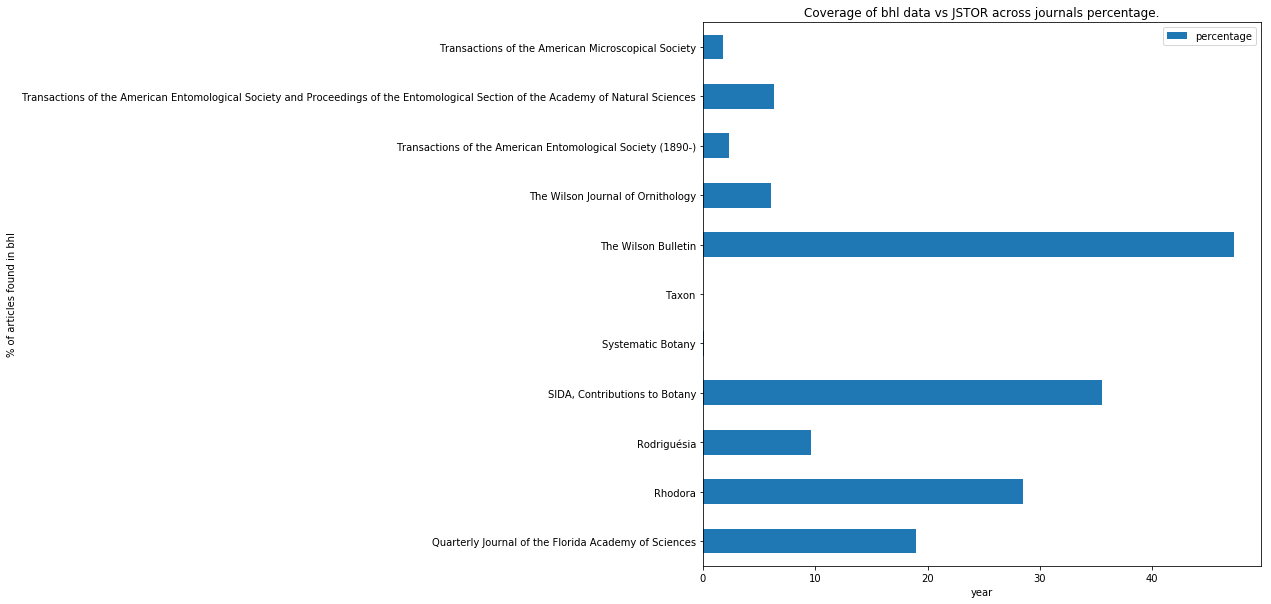

In [135]:
journal_to_ids_count_data_jstor = articles_data.groupby(["journal_name"]).size().reset_index(name="jstor_counts")
# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data, journal_to_ids_count_data_jstor, how="inner", on=["journal_name"])
print(counts_both_merged)
counts_both_merged = counts_both_merged.set_index('journal_name')

# print(journal_to_ids_count_data)
ax = counts_both_merged.plot.barh( rot=0, figsize=(10,10), title='Coverage of bhl data over journals.')
ax.set_xlabel("journals")
ax.set_ylabel("no. of articles found in bhl")
plot.show()
counts_both_merged.boxplot(column=['gs_counts', 'jstor_counts'],figsize=(15,15))
counts_both_merged['percentage'] = counts_both_merged.apply(lambda x: (x.gs_counts/x.jstor_counts)*100, axis=1)
# print(counts_both_merged)
ax = counts_both_merged.plot.barh(y='percentage',rot=0, figsize=(10,10), title='Coverage of bhl data vs JSTOR across journals percentage.')
ax.set_xlabel("year")
ax.set_ylabel("% of articles found in bhl")
plot.show()
# line = plot.barh(journal_to_ids_count_data["counts"][0:50],journal_to_ids_count_data["journal_name"][0:50])
# plot.title("coverage of validation data over journals")
# plot.xlabel('journals')
# plot.ylabel("no. of articles found")
# plot.show()
#todo: include jstor articles. a box plot

Coverage of validation data over journals self.

In [145]:
query = "select ids from self_citations where ids like '%,%'"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
print(gs_data)

articles_query = "select id, journal_name from articles_2_ab"
articles_data = pd.read_sql_query(articles_query,cnx)
# print(articles_data)

merged_data = pd.merge(gs_data, articles_data, how="inner", on=["id"])
# print(merged_data)
merged_data.drop_duplicates()
journal_to_ids_count_data = merged_data.groupby(["journal_name"]).size().reset_index(name="gs_counts")

                   id
0      10.1086/303276
1            43214461
2             4215286
3             4215327
4             4221739
...               ...
79356        43216070
79357        43226878
79358         2656159
79359        41242835
79361        23727916

[63264 rows x 1 columns]


In [144]:
query = "select ids from self_citations where ids like '%,%'"
data = pd.read_sql_query(query,cnx)
print(data)

                           ids
0      10.1086/303276,43214461
1              4215286,4215327
2              4221739,4496006
3              4271331,4272171
4              4536068,4601947
...                        ...
39060        23727979,23728225
39061        23655980,23656017
39062        43216070,43226878
39063         2656159,41242835
39064        23064969,23727916

[39065 rows x 1 columns]


                                          journal_name  gs_counts  \
0                                    A.A.V. Newsletter         87   
1                                            AAV Today          3   
2                                   Abstracta Botanica         96   
3                            Acta Botánica Venezuélica         81   
4                    Advances in Horticultural Science        626   
..                                                 ...        ...   
246  Zeitschrift für Pflanzenkrankheiten (Pflanzenp...        214   
247  Zeitschrift für Pflanzenkrankheiten und Pflanz...          2   
248  Zeitschrift für Pflanzenkrankheiten und Pflanz...       2265   
249                                         Écoscience        281   
250             Österreichische Botanische Zeitschrift        278   

     jstor_counts  
0             320  
1             273  
2             522  
3             750  
4            2900  
..            ...  
246          2293  
247        

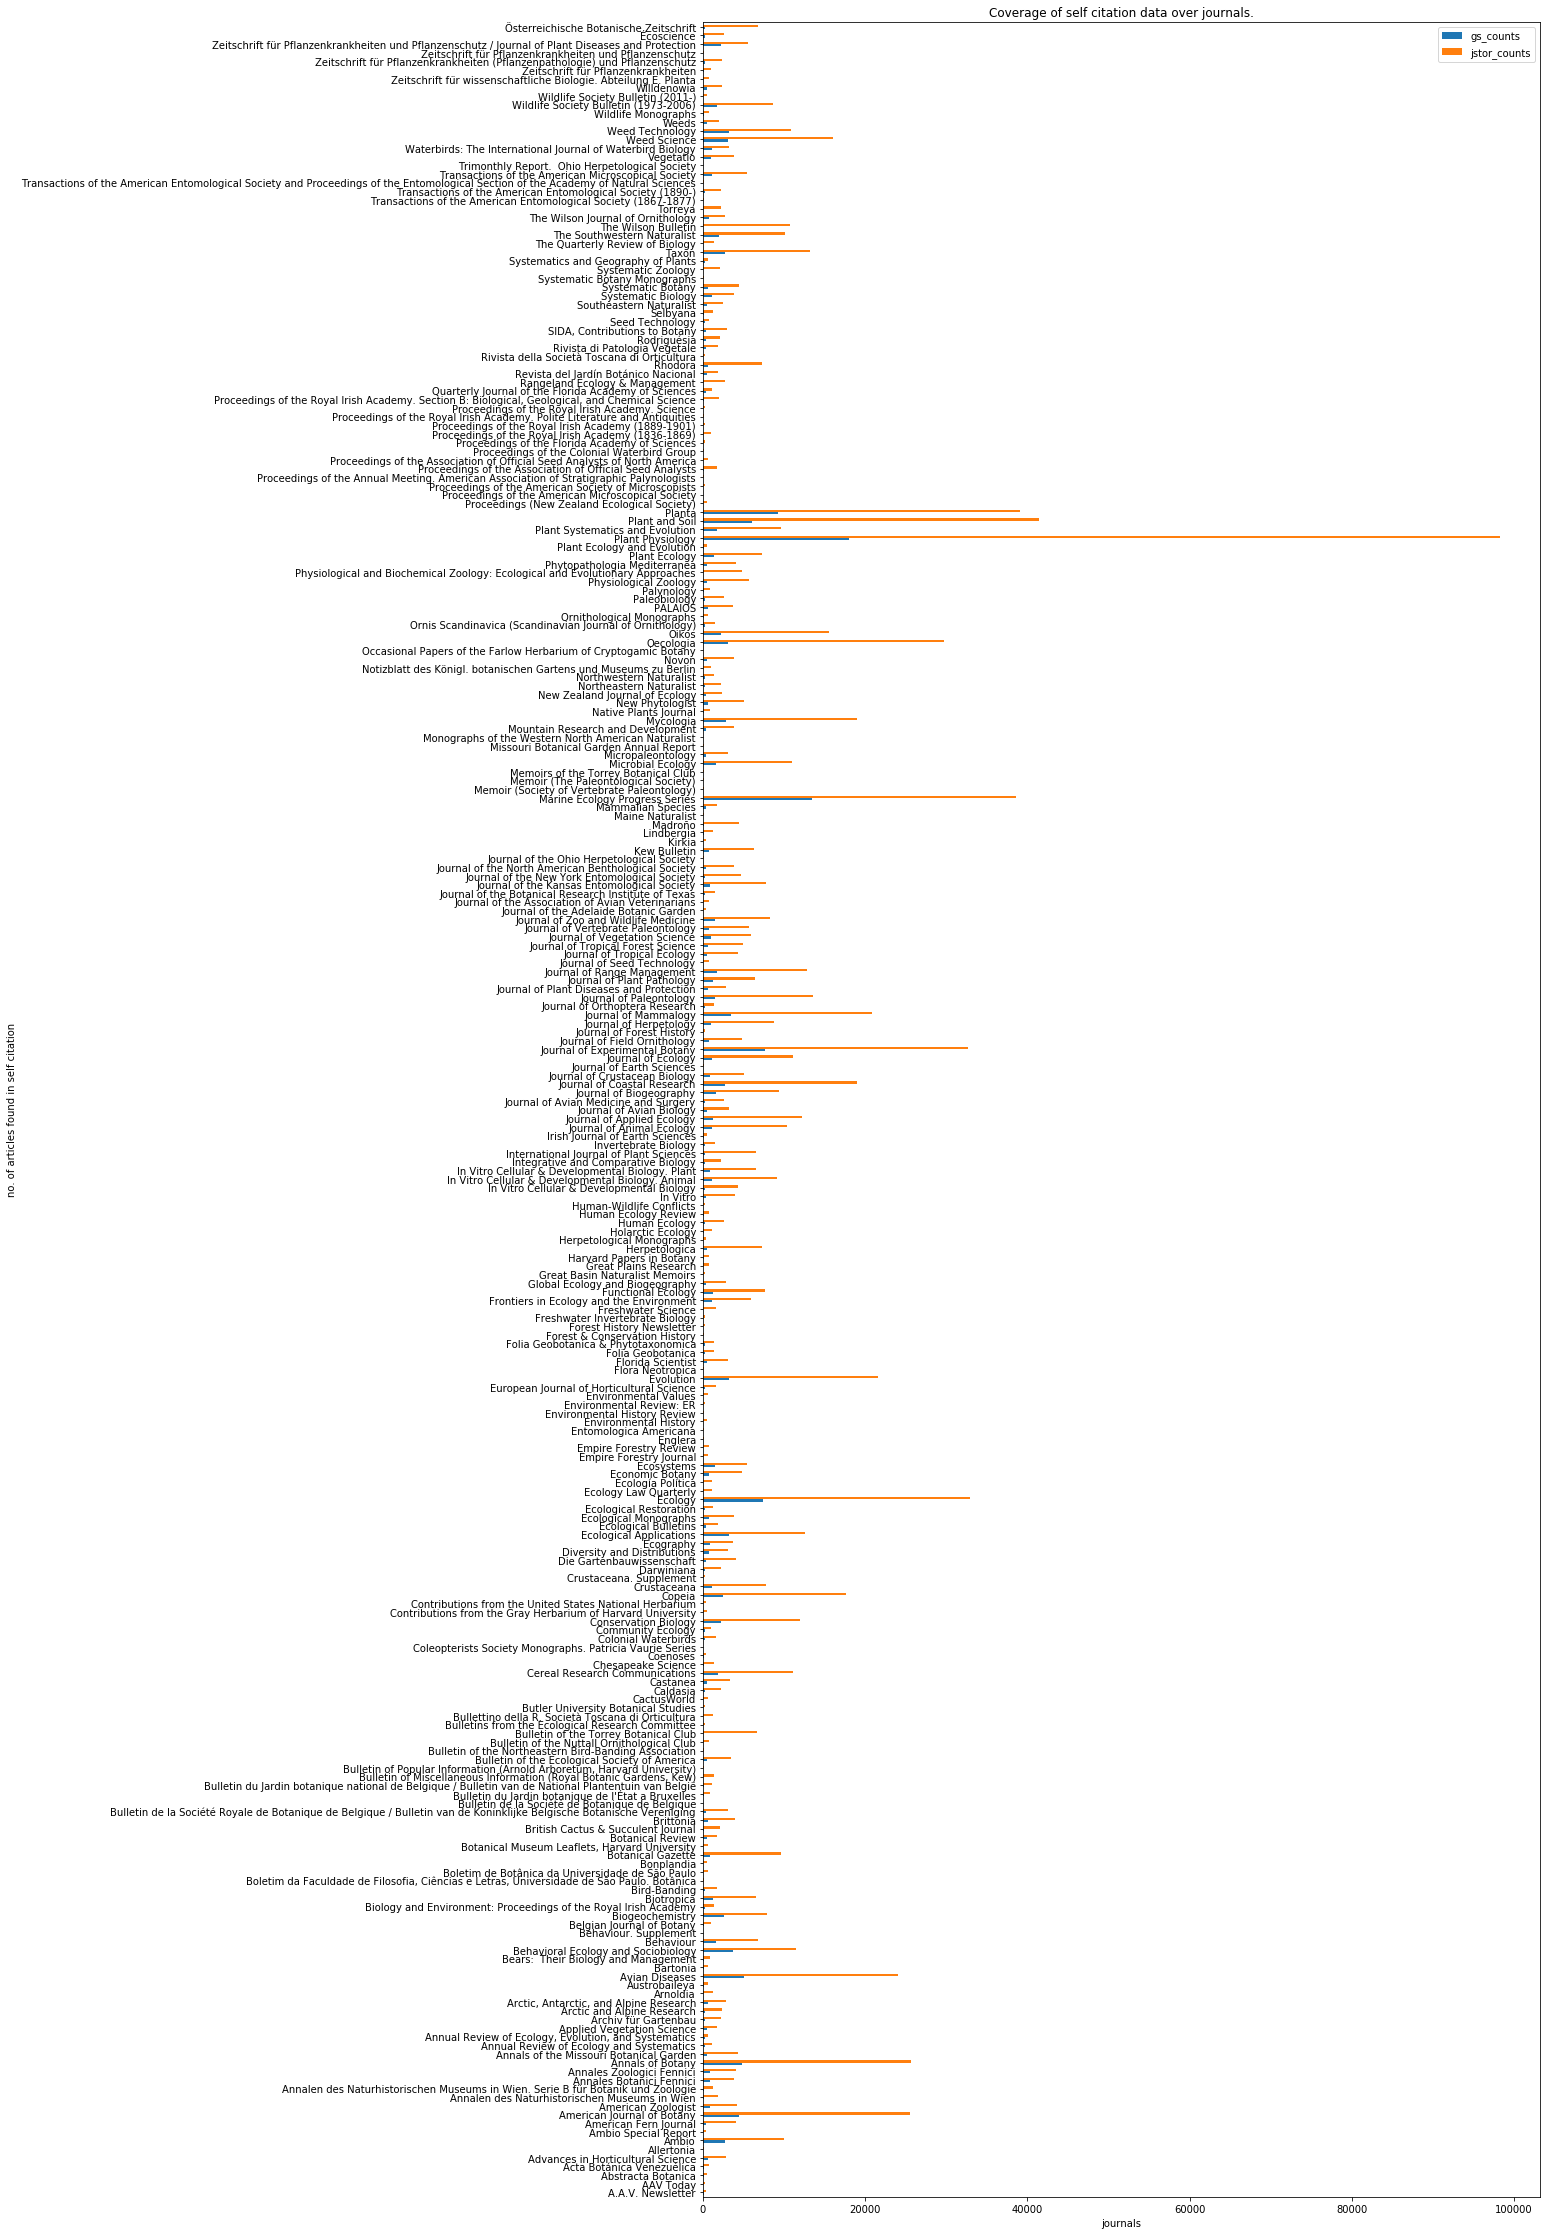

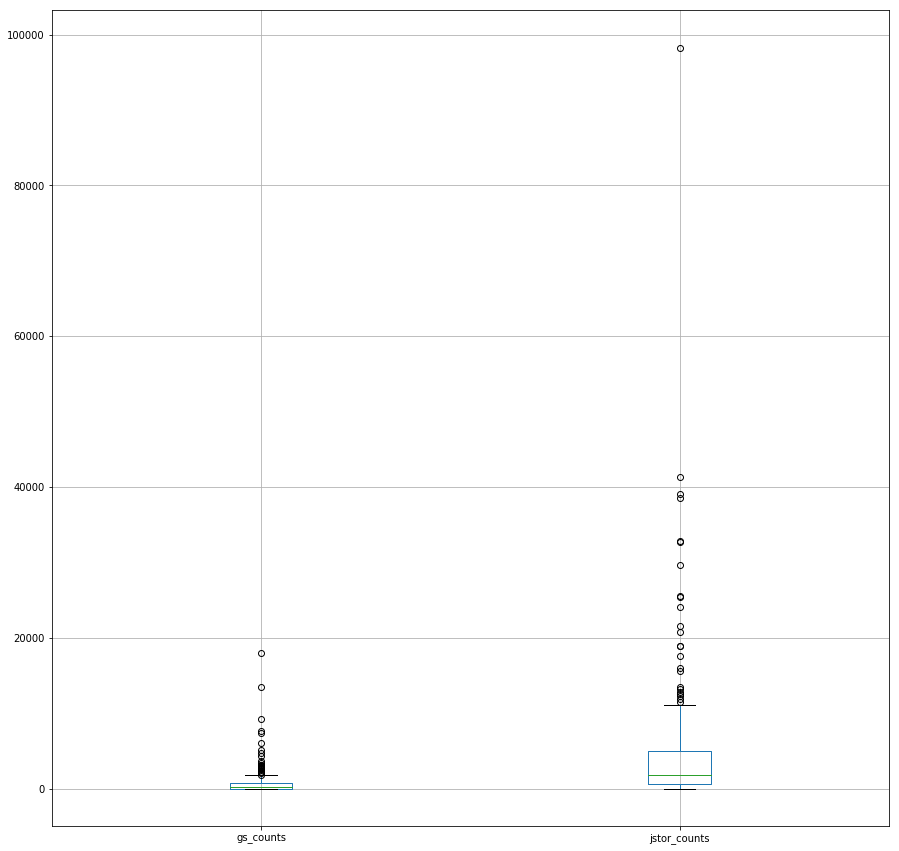

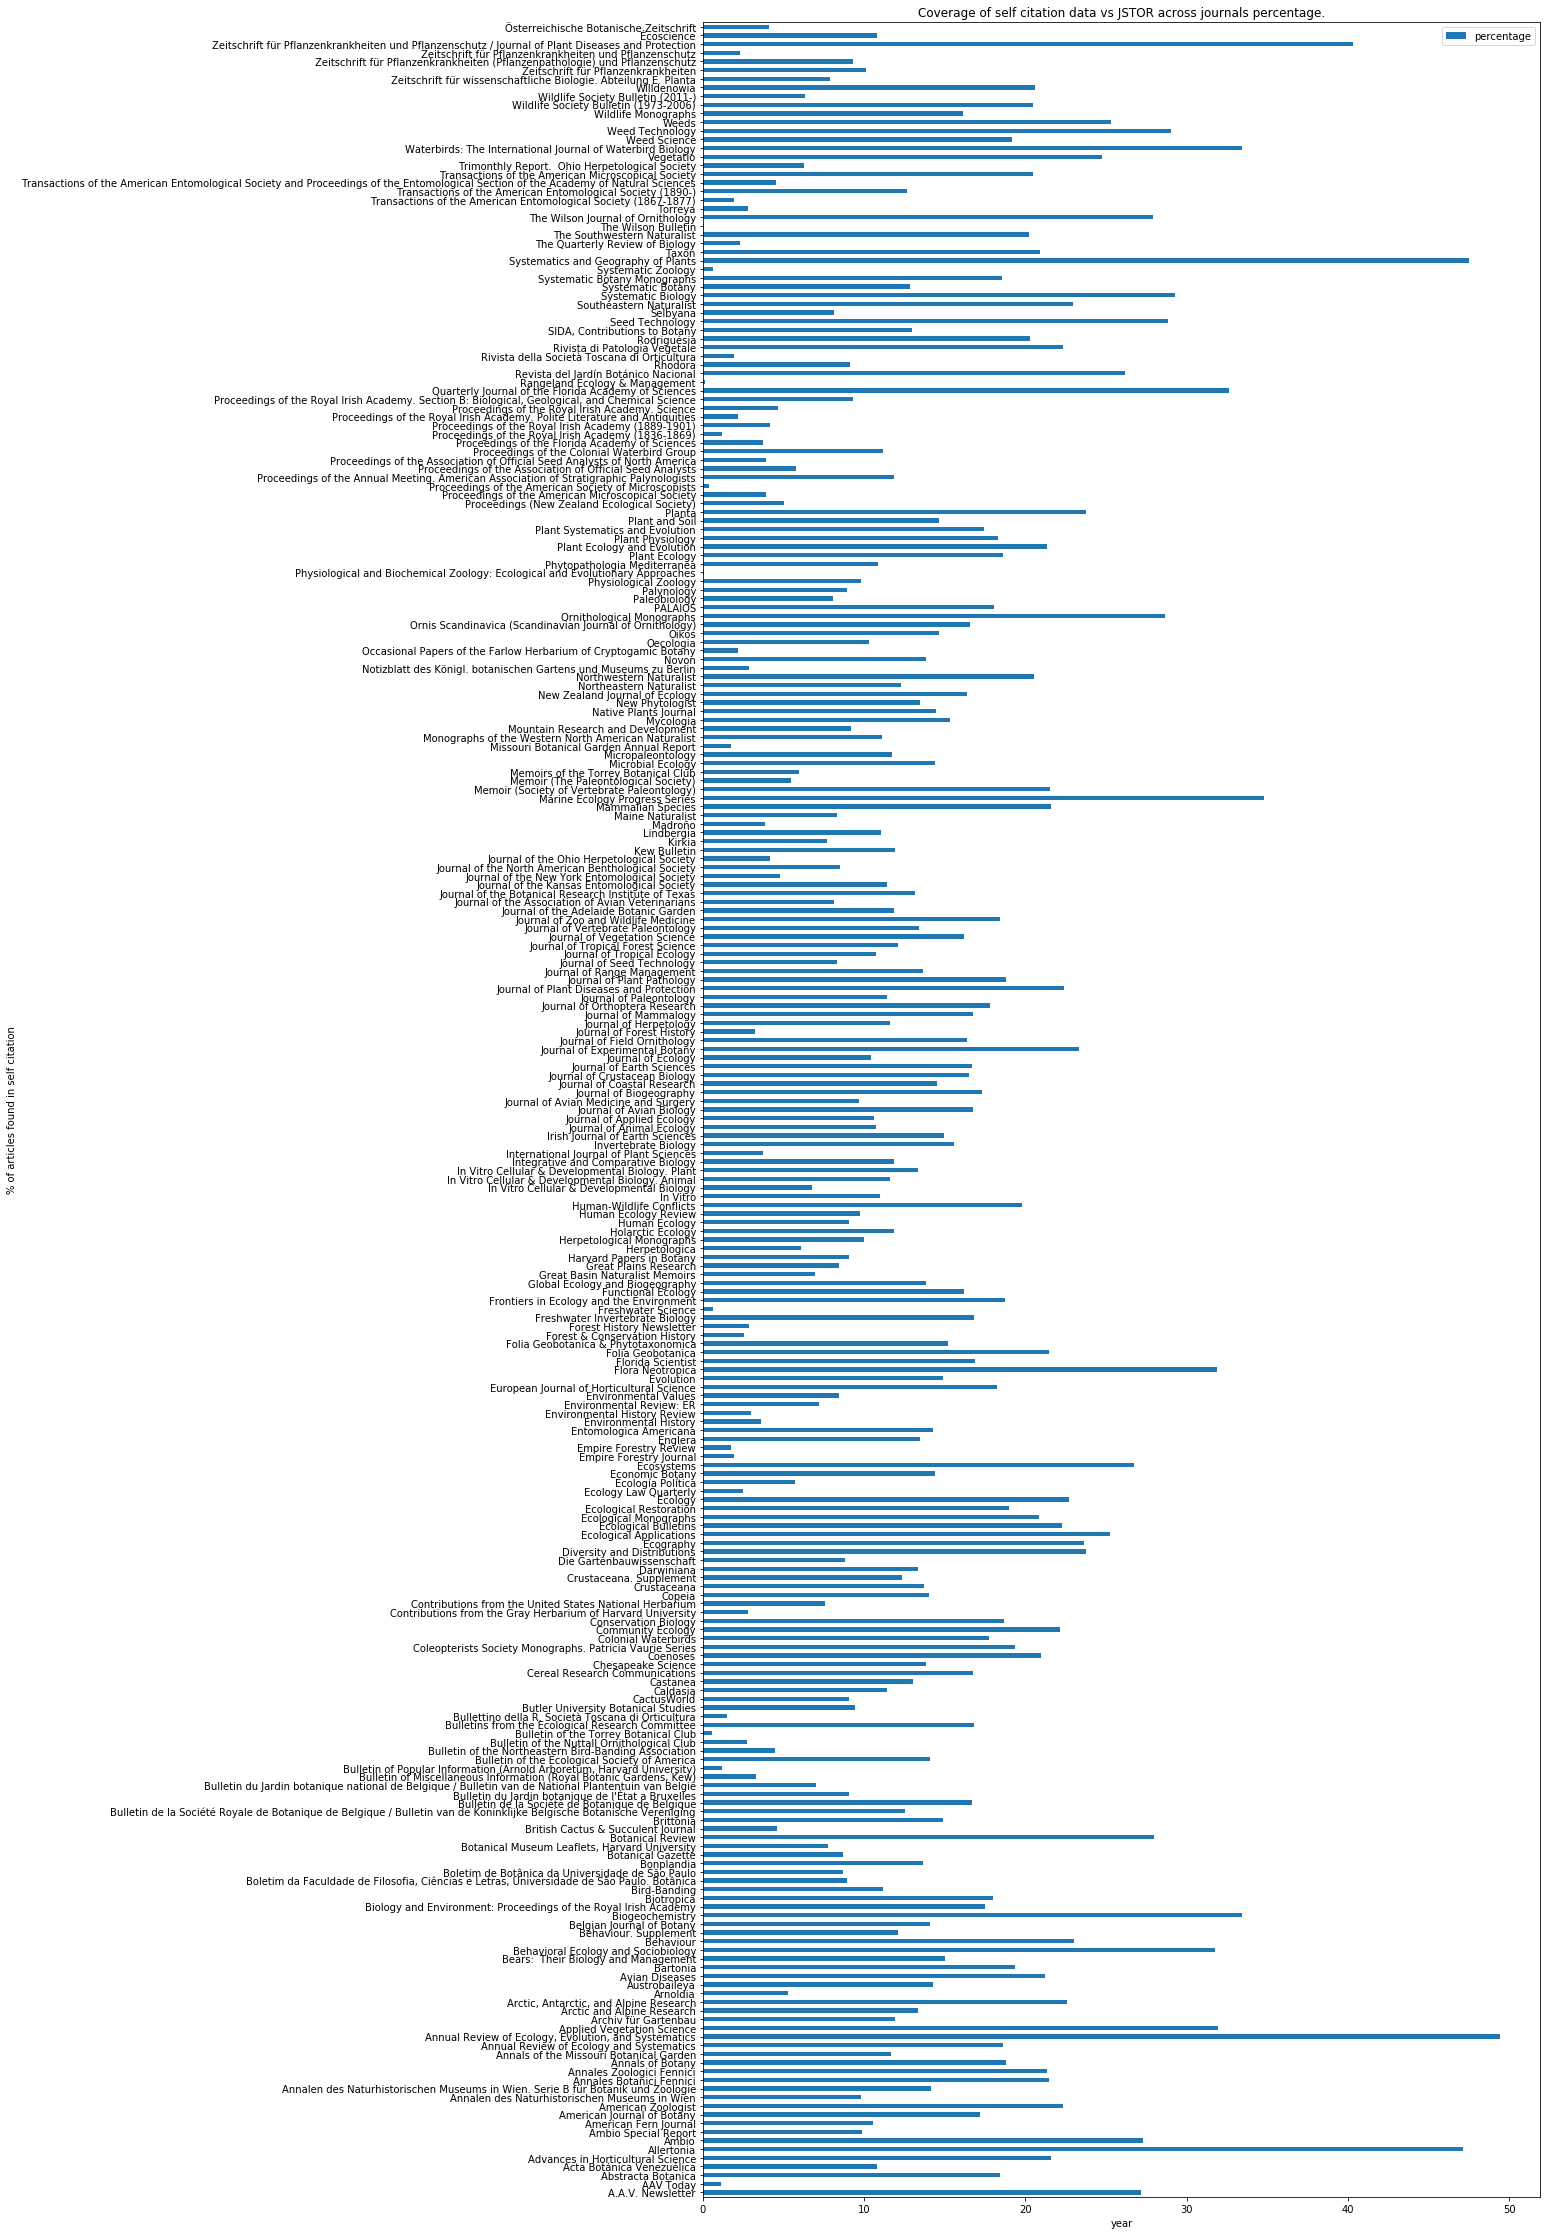

In [146]:
journal_to_ids_count_data_jstor = articles_data.groupby(["journal_name"]).size().reset_index(name="jstor_counts")
# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data, journal_to_ids_count_data_jstor, how="inner", on=["journal_name"])
print(counts_both_merged)
counts_both_merged = counts_both_merged.set_index('journal_name')

# print(journal_to_ids_count_data)
ax = counts_both_merged.plot.barh( rot=0, figsize=(15,40), title='Coverage of self citation data over journals.')
ax.set_xlabel("journals")
ax.set_ylabel("no. of articles found in self citation")
plot.show()
counts_both_merged.boxplot(column=['gs_counts', 'jstor_counts'],figsize=(15,15))
counts_both_merged['percentage'] = counts_both_merged.apply(lambda x: (x.gs_counts/x.jstor_counts)*100, axis=1)
# print(counts_both_merged)
ax = counts_both_merged.plot.barh(y='percentage',rot=0, figsize=(15,40), title='Coverage of self citation data vs JSTOR across journals percentage.')
ax.set_xlabel("year")
ax.set_ylabel("% of articles found in self citation")
plot.show()
# line = plot.barh(journal_to_ids_count_data["counts"][0:50],journal_to_ids_count_data["journal_name"][0:50])
# plot.title("coverage of validation data over journals")
# plot.xlabel('journals')
# plot.ylabel("no. of articles found")
# plot.show()
#todo: include jstor articles. a box plot

Distributions of the r-values for the individual similarity scores.

[-1.505563276437108, -0.5835487704963817, 0.5304508004397505, 0.2556084684936137]


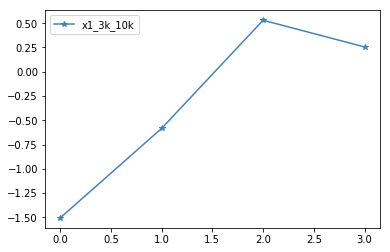

[0.0010897995285305644, -0.08435391387514808]


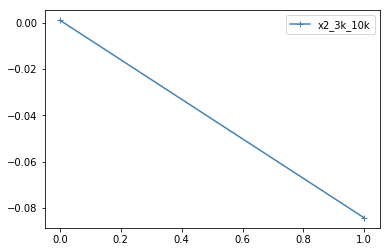

[-1.4959956206741285, -0.5769168181926305, 0.5220685216869461, 0.2517106964225831]


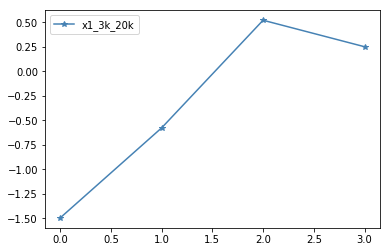

[0.002712682530018212, -0.19795109159885352]


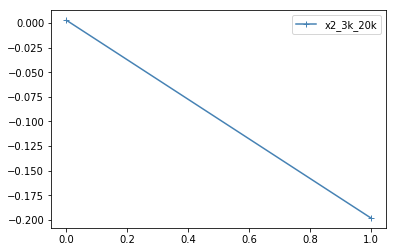

[-1.5075528319304896, -0.6365717610459778, 0.558140792569096, 0.2588122860088636]


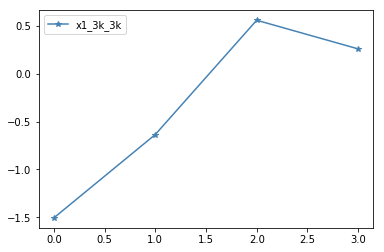

[0.0031526669684361097, -0.22661898646842527]


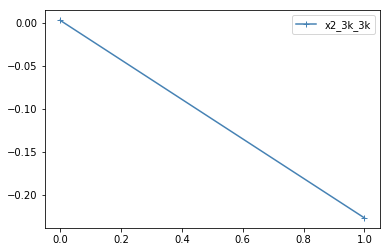

[-3.928182913323189, -3.267955048792749, -3.6352786528092174, -0.964421553599061, -1.0428004555236583, -1.9231535636205175, 0.0890160945530012, -1.2973942691190756, 2.4634708036600874, 1.238953535338523, 3.1614413310490277]


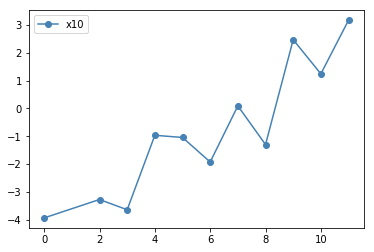

[-0.32743573358949996, 1.678347087175146, 3.5698853572710125, 5.216521434174919, 6.696612476506944, 7.63697228983691, 8.406012260917183, 8.297048554371024, 8.961199997336873, 9.850692536056304, 9.488712539887878, 10.002936637612981]


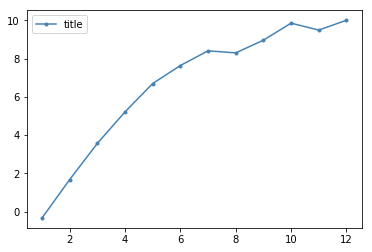

[-0.4841564974197476, 3.350144264631186]


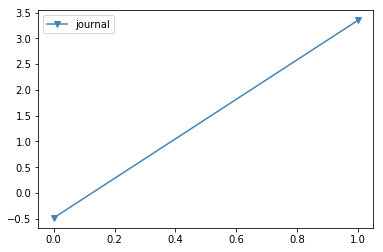

[-0.1220700061663943, 5.779938928908937, 6.429321895652056, 5.9117939541551285, 6.861379524181934, 7.87750000409541, 8.07593064319682, 8.05626283827237, 7.175432157777085, 7.640044938387945, 6.044030046285984]


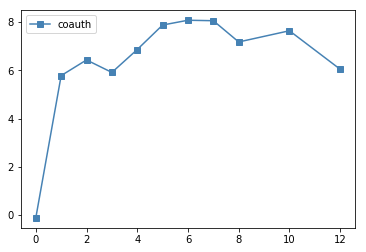

[-0.21857857168954656, 0.12919974727294423, 1.42386505505258, 2.4201499861673215, 3.4010196109704403, 4.355474501485883, 5.273913794041706, 6.086589660704781, 6.735062315941304, 7.320788520337568, 7.838815236430577, 8.346615139280031, 7.705427697650796, 8.423576180416159, 8.172261752135253]


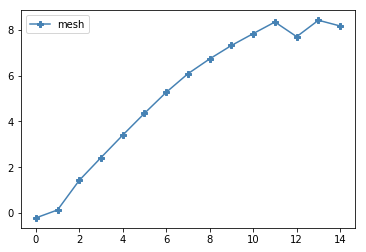

[0.7914095149069613, -0.6754549617508927, 0.026957347800331974]


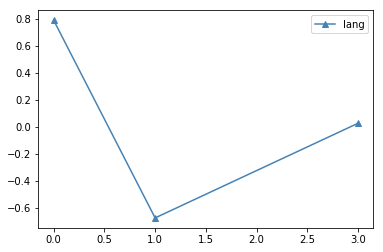

<Figure size 1600x2400 with 0 Axes>

In [3]:
import json
import math
with open("../r_table/compute_r/results/r_x1_3k_10k.json") as f:
    values = json.load(f)
# del values["total_profiles"]
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y, marker='*',label = "x1_3k_10k", color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x2_3k_10k.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y,  marker='+',label = "x2_3k_10k", color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x1_3k_20k.json") as f:
    values = json.load(f)
# del values["total_profiles"]
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y, marker='*',label = "x1_3k_20k", color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x2_3k_20k.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y,  marker='+',label = "x2_3k_20k", color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x1_3k3k.json") as f:
    values = json.load(f)
# del values["total_profiles"]
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y, marker='*',label = "x1_3k_3k", color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x2_3k3k.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y,  marker='+',label = "x2_3k_3k", color='steelblue')
plot.legend()
plot.show()

# with open("../r_table/r_final.json") as f:
#     values = json.load(f)
# if "total_profiles" in r_xa:
#     del r_xa["total_profiles"]
# x = sorted([int(k) for k in values.keys()])
# y = [values[str(key)] for key in x]

# plot.plot(x, y, label = "x3")

with open("../r_table/compute_r/results/r_x10.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y, label = "x10",  marker='o', color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x3.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y, label = "title", marker='.', color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x4.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
# print(x)
print(y)
plot.plot(x, y, label = "journal",  marker='v', color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x5.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y, label = "coauth", marker='s', color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x6.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)

plot.plot(x, y, label = "mesh", marker='P', color='steelblue')
plot.legend()
plot.show()

with open("../r_table/compute_r/results/r_x7.json") as f:
    values = json.load(f)
x = sorted([int(k) for k in values.keys()])
y = [math.log(values[str(key)]) for key in x]
print(y)
plot.plot(x, y, label = "lang", marker='^', color='steelblue')
plot.legend()
plot.figure(figsize=(20, 30), dpi=80)

plot.show()

# plt.plot(y, x, label = "line 2")
# plt.plot(x, np.sin(x), label = "curve 1")
# plt.plot(x, np.cos(x), label = "curve 2")
# plot.legend()
# plot.show()

In [6]:
#analysis
query = "SELECT distinct last_name, first_initial FROM articles_2_ab"
FINI_df = pd.read_sql_query(query,cnx)
print(FINI_df)

query = "SELECT distinct last_name, first_initial, middle_initial FROM articles_2_ab"
AINI_df = pd.read_sql_query(query,cnx)
print(AINI_df)

query = "SELECT distinct fullname FROM articles_2_ab"
unique_author_strings_df = pd.read_sql_query(query,cnx)
print(unique_author_strings_df)



            last_name first_initial
0              Takeda             H
1            Director             F
2               Lange             R
3       Werminghausen             J
4              Anthes             N
...               ...           ...
294726        Timpson             M
294727          Essex             J
294728           Sgro             M
294729          Greve             D
294730        Klemash             D

[294731 rows x 2 columns]
            last_name first_initial middle_initial
0              Takeda             H               
1            Director             F              B
2               Lange             R               
3       Werminghausen             J               
4              Anthes             N               
...               ...           ...            ...
377906           Dean             J              P
377907           Sgro             M              P
377908       Heckmann             K              E
377909          Greve          

In [6]:
#intersection of validation data
query = "select ids from google_scholar"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
print(gs_data)


query = "select ids from bhl"
data = pd.read_sql_query(query,cnx)
bhl_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
bhl_data = bhl_data.drop_duplicates()
bhl_data = bhl_data[0].to_frame()
bhl_data = bhl_data.rename(columns={0:"id"})
print(bhl_data)


intersection_data = pd.merge(gs_data, bhl_data, how="inner", on=["id"])
print(intersection_data)

#596 articles in common between gs and bhl

query = "select ids from self_citations where ids like '%,%'"
data = pd.read_sql_query(query,cnx)
self_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
self_data = self_data.drop_duplicates()
self_data = self_data[0].to_frame()
self_data = self_data.rename(columns={0:"id"})
print(self_data)

three_data = pd.merge(intersection_data, self_data, how="inner", on=["id"])
print(three_data)

#22 articles in common between all three

intersection_data_gs_self = pd.merge(gs_data, self_data, how="inner", on=["id"])
print(intersection_data_gs_self)

intersection_data_bhl_self = pd.merge(bhl_data, self_data, how="inner", on=["id"])
print(intersection_data_bhl_self)

#14094 in common with gs and self
#248 in common with bhl and self

             id
0       4315162
2       4280408
3       4095003
4       4498709
5       4095942
...         ...
78486   3873106
78487   3873105
78488  40985550
78489  20048692
78490   3677614

[70710 rows x 1 columns]
            id
0     24314766
2     24313675
3     24314767
4     24314921
5     24314995
...        ...
9000  20455965
9001  20455963
9003  20455990
9006  20456037
9009  20456029

[4817 rows x 1 columns]
           id
0     4164436
1     4164436
2     4164436
3     4164436
4     4164623
..        ...
591   4163930
592   4163954
593   4164063
594  41968352
595  41968352

[596 rows x 1 columns]
                   id
0      10.1086/303276
1            43214461
2             4215286
3             4215327
4             4221739
...               ...
79356        43216070
79357        43226878
79358         2656159
79359        41242835
79361        23727916

[63264 rows x 1 columns]
          id
0   20455963
1   23313563
2   23313563
3   23313320
4   20455888
5   20455888
6   

In [5]:
query = "select distinct language from articles_2_ab where language!='eng'"
data = pd.read_sql_query(query,cnx)
print(data)

query = "select count(distinct id),language from articles_2_ab group by language"
data = pd.read_sql_query(query,cnx)
print(data)

           language
0               ger
1               fre
2                en
3               spa
4               ita
5               dut
6           ger lat
7               lat
8               hun
9           eng rus
10              por
11          eng hun
12          spa lat
13          eng lat
14              rus
15          spa por
16          lat eng
17          lat ger
18      eng lat ger
19      ger ita lat
20              nor
21              tru
22          fre lat
23          eng fre
24          spa eng
25      eng ger lat
26          ger eng
27              esp
28              nig
29              rom
30          lat spa
31      ger eng lat
32          eng spa
33  ger eng lat fre
34      ger lat fre
35          eng dut
36          ita lat
37          por eng
38          ger ita
39          eng ger
40      ger fre lat
41      eng ger fre
42               EN
43          fre eng
44          ita eng
45          eng ita
46      eng ger spa
47                 
48               ru


                     id  year
0              43215559  2004
1       10.2307/4072856  1918
2              41288662  2011
3       10.2307/4111792  1912
4               4312676  1981
...                 ...   ...
533379         41717298  2003
533380         41717310  2003
533381         41717296  2003
533382         41717299  2003
533383         41717301  2003

[533384 rows x 2 columns]
    year  gs_counts  jstor_counts
0   1900          1           894
1   1901          1          1009
2   1902          2          1158
3   1927          2          1355
4   1928          1          1446
..   ...        ...           ...
77  2013       2720          8478
78  2014       1047          3353
79  2015        193          1155
80  2016        119           461
81  2017         45           214

[82 rows x 3 columns]
                   id
0      10.1086/303276
1            43214461
2             4215286
3             4215327
4             4221739
...               ...
79356        43216070
79357 

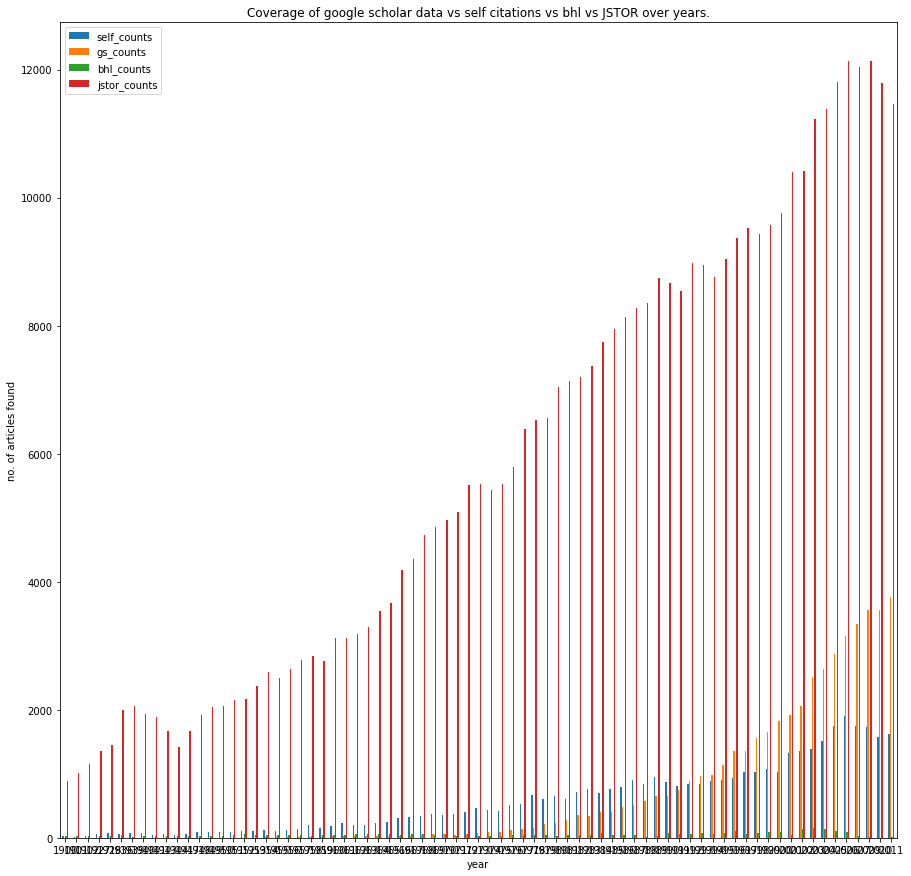

In [6]:
query = "select ids from google_scholar"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
# print(gs_data)



articles_query = "select id, year from publication"
articles_data = pd.read_sql_query(articles_query,cnx)
print(articles_data)

merged_data_gs = pd.merge(gs_data, articles_data, how="inner", on=["id"])
# print(merged_data_gs)
merged_data_gs.drop_duplicates()

journal_to_ids_count_data = merged_data_gs.groupby(["year"]).size().reset_index(name="gs_counts")
journal_to_ids_count_data_jstor = articles_data.groupby(["year"]).size().reset_index(name="jstor_counts")
# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data, journal_to_ids_count_data_jstor, how="inner", on=["year"])
print(counts_both_merged)

query = "select ids from self_citations where ids like '%,%'"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
print(gs_data)


merged_data_self = pd.merge(gs_data, articles_data, how="inner", on=["id"])
print(merged_data_self)
merged_data_self.drop_duplicates()


journal_to_ids_count_data_self = merged_data_self.groupby(["year"]).size().reset_index(name="self_counts")
journal_to_ids_count_data_jstor = articles_data.groupby(["year"]).size().reset_index(name="jstor_counts")
print(counts_both_merged)

# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data_self, journal_to_ids_count_data_jstor, how="inner", on=["year"])
counts_both_merged = pd.merge(journal_to_ids_count_data,counts_both_merged, how="inner", on=["year"])
print(counts_both_merged)

query = "select ids from bhl"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
print(gs_data)


merged_data_self = pd.merge(gs_data, articles_data, how="inner", on=["id"])
print(merged_data_self)
merged_data_self.drop_duplicates()


journal_to_ids_count_data_bhl = merged_data_self.groupby(["year"]).size().reset_index(name="bhl_counts")
# journal_to_ids_count_data_jstor = articles_data.groupby(["year"]).size().reset_index(name="jstor_counts")
print(counts_both_merged)

# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data_bhl, journal_to_ids_count_data_jstor, how="inner", on=["year"])
counts_both_merged = pd.merge(journal_to_ids_count_data,counts_both_merged, how="inner", on=["year"])
counts_both_merged = pd.merge(journal_to_ids_count_data_self,counts_both_merged, how="inner", on=["year"])
print(counts_both_merged)

# print(counts_both_merged)
# counts_both_merged.reset_index()
counts_both_merged.to_excel('validation_data_across_years.xlsx')

counts_both_merged = counts_both_merged.set_index('year')

ax = counts_both_merged.plot.bar(rot=0, figsize=(15,15), title='Coverage of google scholar data vs self citations vs bhl vs JSTOR over years.')
ax.set_xlabel("year")
ax.set_ylabel("no. of articles found")
plot.show()


                      id                                       journal_name
0        10.2307/4111792  Bulletin of Miscellaneous Information (Royal B...
1                4312676                                              Ambio
2               23500443                Behavioral Ecology and Sociobiology
3               23500443                Behavioral Ecology and Sociobiology
4               23500443                Behavioral Ecology and Sociobiology
...                  ...                                                ...
1212877         41717296                  Western North American Naturalist
1212878         41717299                  Western North American Naturalist
1212879         41717299                  Western North American Naturalist
1212880         41717301                  Western North American Naturalist
1212881         41717301                  Western North American Naturalist

[1212882 rows x 2 columns]
                              journal_name  gs_counts  jstor

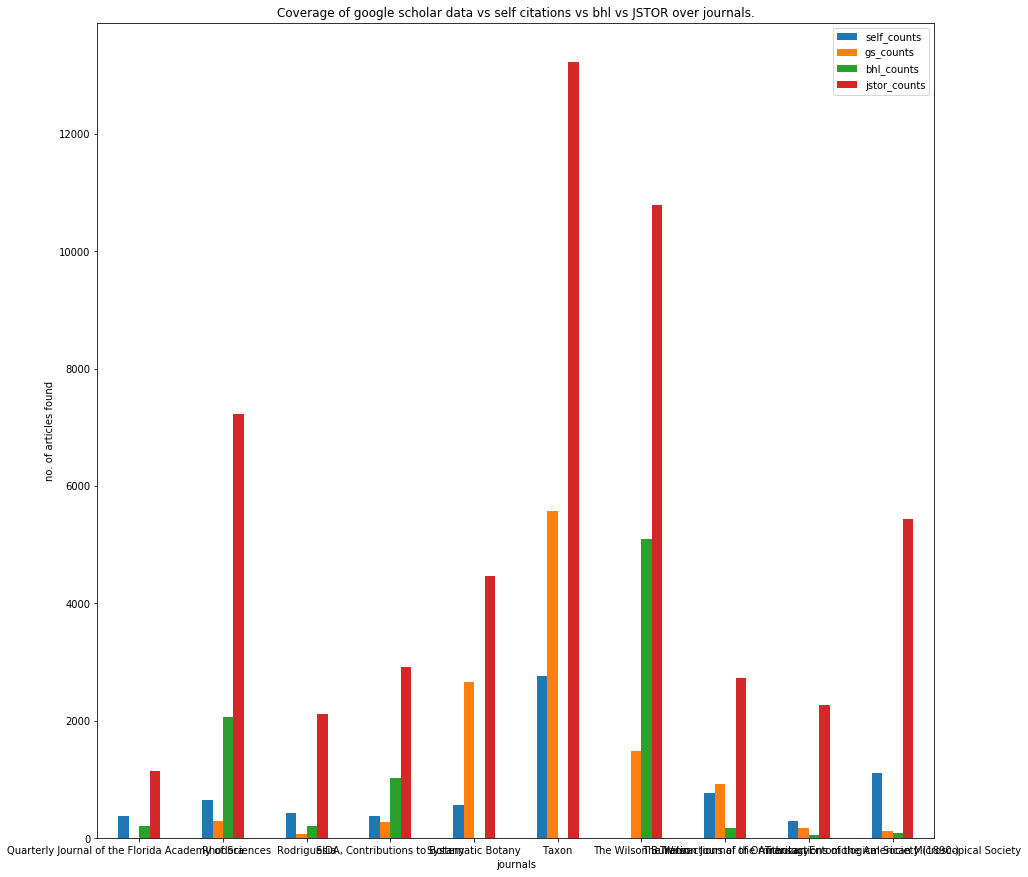

In [9]:
query = "select ids from google_scholar"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
# print(gs_data)



articles_query = "select id, journal_name from articles_2_ab"
articles_data = pd.read_sql_query(articles_query,cnx)
print(articles_data)

merged_data_gs = pd.merge(gs_data, articles_data, how="inner", on=["id"])
# print(merged_data_gs)
merged_data_gs.drop_duplicates()

journal_to_ids_count_data = merged_data_gs.groupby(["journal_name"]).size().reset_index(name="gs_counts")
journal_to_ids_count_data_jstor = articles_data.groupby(["journal_name"]).size().reset_index(name="jstor_counts")
# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data, journal_to_ids_count_data_jstor, how="inner", on=["journal_name"])
print(counts_both_merged)

query = "select ids from self_citations where ids like '%,%'"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
print(gs_data)


merged_data_self = pd.merge(gs_data, articles_data, how="inner", on=["id"])
print(merged_data_self)
merged_data_self.drop_duplicates()


journal_to_ids_count_data_self = merged_data_self.groupby(["journal_name"]).size().reset_index(name="self_counts")
journal_to_ids_count_data_jstor = articles_data.groupby(["journal_name"]).size().reset_index(name="jstor_counts")
print(counts_both_merged)

# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data_self, journal_to_ids_count_data_jstor, how="inner", on=["journal_name"])
counts_both_merged = pd.merge(journal_to_ids_count_data,counts_both_merged, how="inner", on=["journal_name"])
print(counts_both_merged)

query = "select ids from bhl"
data = pd.read_sql_query(query,cnx)
gs_data = pd.concat([pd.Series(row['ids'].split(','))              
                    for _, row in data.iterrows()]).reset_index()
gs_data = gs_data.drop_duplicates()
gs_data = gs_data[0].to_frame()
gs_data = gs_data.rename(columns={0:"id"})
print(gs_data)


merged_data_self = pd.merge(gs_data, articles_data, how="inner", on=["id"])
print(merged_data_self)
merged_data_self.drop_duplicates()


journal_to_ids_count_data_bhl = merged_data_self.groupby(["journal_name"]).size().reset_index(name="bhl_counts")
# journal_to_ids_count_data_jstor = articles_data.groupby(["year"]).size().reset_index(name="jstor_counts")
print(counts_both_merged)

# print(journal_to_ids_count_data_jstor)
counts_both_merged = pd.merge(journal_to_ids_count_data_bhl, journal_to_ids_count_data_jstor, how="inner", on=["journal_name"])
counts_both_merged = pd.merge(journal_to_ids_count_data,counts_both_merged, how="inner", on=["journal_name"])
counts_both_merged = pd.merge(journal_to_ids_count_data_self,counts_both_merged, how="inner", on=["journal_name"])
print(counts_both_merged)

print(counts_both_merged)
# counts_both_merged.reset_index()
counts_both_merged.to_excel('validation_data_across_journals.xlsx')

counts_both_merged = counts_both_merged.set_index('journal_name')

ax = counts_both_merged.plot.bar(rot=0, figsize=(15,15), title='Coverage of google scholar data vs self citations vs bhl vs JSTOR over journals.')
ax.set_xlabel("journals")
ax.set_ylabel("no. of articles found")
plot.show()


In [9]:
query = "select id, position from articles_2"
data_prev = pd.read_sql_query(query,cnx)
print(data_prev)

query = "select id, position from articles_2_ab"
data = pd.read_sql_query(query,cnx)
print(data)



                               id  position
0                  10.1086/529557         1
1                  10.1086/529558         1
2                  10.1086/529559         1
3                  10.1086/529559         2
4                  10.1086/529560         1
...                           ...       ...
153148  wildsocibull2011.38.4.874         1
153149  wildsocibull2011.38.4.878         1
153150  wildsocibull2011.38.4.884         1
153151  wildsocibull2011.38.4.887         1
153152  wildsocibull2011.38.4.892         1

[153153 rows x 2 columns]
                                id  position
0                           09-022         1
1                           09-022         2
2                          09-031R         1
3                          09-031R         2
4                          09-031R         3
...                            ...       ...
1212877  wildsocibull2011.38.4.874         1
1212878  wildsocibull2011.38.4.878         1
1212879  wildsocibull2011.38.4.884      

TypeError: unhashable type: 'list'

In [10]:
final_data = pd.merge(data_prev, data, on=["id","position"], how="inner")
print(final_data)

                               id  position
0                  10.1086/529557         1
1                  10.1086/529558         1
2                  10.1086/529559         1
3                  10.1086/529559         2
4                  10.1086/529560         1
...                           ...       ...
153147  wildsocibull2011.38.4.874         1
153148  wildsocibull2011.38.4.878         1
153149  wildsocibull2011.38.4.884         1
153150  wildsocibull2011.38.4.887         1
153151  wildsocibull2011.38.4.892         1

[153152 rows x 2 columns]


In [15]:
query = "select distinct id from articles"
data = pd.read_sql_query(query,cnx)
print(data)

                               id
0                          09-022
1                         09-031R
2                         09-049R
3                         09-076R
4                         09-080R
...                           ...
514858  wildsocibull2011.38.4.874
514859  wildsocibull2011.38.4.878
514860  wildsocibull2011.38.4.884
514861  wildsocibull2011.38.4.887
514862  wildsocibull2011.38.4.892

[514863 rows x 1 columns]


In [14]:
#renames and stuff
query = "ALTER TABLE articles_2_ab RENAME TO articles"
cursor.execute(query)
cnx.commit()

OperationalError: no such table: articles_2_ab